09.03.2024

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


# Matplolib default parameters
from matplotlib import rcParams
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

# import warning
import warnings
warnings.filterwarnings('ignore')

# Set option max columns display
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import metrics 
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [10]:
# %config InlineBackend.figure_format = 'retina'

# sns.set(style='whitegrid', palette='deep')

# plt.rcParams['figure.figsize'] = 8, 5
# plt.rcParams['font.size'] = 12
# plt.rcParams['savefig.format'] = 'pdf'

In [4]:
df_2023 = pd.read_excel('full_dfs/df_2023_full.xlsx')
df_2021 = pd.read_excel('full_dfs/df_2021_full.xlsx')
df_2020 = pd.read_excel('full_dfs/df_2020_full.xlsx')
df_2019 = pd.read_excel('full_dfs/df_2019_full.xlsx')
df_bank_ids = pd.read_excel('full_dfs/bank_ids.xlsx')

In [5]:
df_bank_ids.shape

(353, 2)

In [6]:
df_2023

bank_name  Вложения в ценные бумаги  \
0                           Сбербанк              6.292502e+09   
1                                ВТБ              4.693619e+09   
2                        Газпромбанк              1.471975e+09   
3                         Альфа-Банк              1.072772e+09   
4    Московский кредитный банк (МКБ)              8.645898e+08   
..                               ...                       ...   
334                          АЗИЯПЭЙ                       NaN   
335                  Промсвязьинвест                       NaN   
336  «Петербургский Расчетный Центр»              2.080000e+02   
337                 «Дальний Восток»                       NaN   
338                          «ИНЭКО»                       NaN   

     Кредитный портфель  Просроченная задолженность в кредитном портфеле  \
0          3.656594e+10                                      155268282.0   
1          1.573751e+10                                      135018281.0   
2          1.024813e+10                                       58494498.0   
3          5.716990e+09                                       23056930.0   
4          3.129535e+09                                       29047964.0   
..                  ...                                              ...   
334                 NaN                                              NaN   
335                 NaN                                              NaN   
336                 NaN                                              NaN   
337                 NaN                                              NaN   
338                 NaN                                              NaN   

     Активы нетто    Векселя  Вклады физических лиц  Вложения в акции  \
0     50695718774   77202098            11458178474          45827036   
1     26188218945   44638934             4579261369          83808718   
2     15296029418  106779045             1592032837          26906711   
3      8411400483   22954997             1383959353          28971157   
4      4971033526          0              514246382          20754861   
..            ...        ...                    ...               ...   
334        189126          0                      0                 0   
335        185626          0                      0                 0   
336        167242          0                      0               208   
337        155969          0                      0                 0   
338        108776          0                      0                 0   

     Вложения в векселя  Вложения в капиталы других организаций  \
0                580517                              1270984158   
1                     0                              1072255743   
2                     0                               541594156   
3                  1000                                15415862   
4                     0                                 8056345   
..                  ...                                     ...   
334                   0                                       0   
335                   0                                       0   
336                   0                                      45   
337                   0                                       0   
338                   0                                       0   

     Вложения в облигации  Выданные МБК  Выпущенные облигации и векселя  \
0              6246094682    1016170304                       721975229   
1              4609809811     760271572                       189180751   
2              1445068672     364484845                       314108805   
3              1043800235     507862071                       221421881   
4               843834949     497847392                        30659871   
..                    ...           ...                             ...   
334                     0        185600                               0   
335                     0        156000

### 2021 - 2023

In [7]:
df_2023['ROA'] = df_2023['Чистая прибыль'] / df_2023['Активы нетто']
df_2023['ROE'] = df_2023['Чистая прибыль'] / df_2023['Капитал (по форме 123)']

In [8]:
df_2023 = df_2023.rename(columns = {
                          'Уровень просроченной задолженности по кредитному портфелю' : 'NPL Ratio',
                          'Н2' : 'Н2 liquidity',
                          'Н3' : 'Н3 liquidity',
                          'Н1' : 'Н1 CAR',
                          'Активы нетто': 'Total Assets',
                          'Капитал (по форме 123)' : 'Капитал'})

In [9]:
from clustering_functions import labels_2021_2023

In [10]:
df_2021 = labels_2021_2023(df_2021)
df_2023 = labels_2021_2023(df_2023)

# Собираем осмысленные переменные

- На смартлабе есть некоторые показатели за 2022 и 2023, но там только для банков, торгующихся на бирже https://smart-lab.ru/q/SBER/f/y/

### Banks’ risk clustering using k-means: a method based on size and individual & systemic risks
https://drive.google.com/file/d/1FM3AV05f2CrFG5oDe0lKZ3H9cftbDheo/view

The factor called __RatioBS__ measures banks’ exposures using balance sheet ratios, such as: 
- ??? `debt / total assets` <br>
__debt__ = long term borrowings (*Кредиты сроком более 1 года ЮЛ + ФЛ*) + short term borrowings (*Кредиты сроком до 1 года ЮЛ + ФЛ*) + securities sold with repurchase agreements (*Бумаги переданные в РЕПО*). <br>
total assets = *Активы нетто*
- `deposit / total assets` <br>
__deposit__ = total deposits received from customers (*ФЛ Счета + ЮЛ Счета?*)
- `total loans / total assets` - It shows to what extent a bank is engaged in non-classical banking activities. If the value is low, then a bank has a high interbank or trading exposure.<br> 
total loans = *Кредиты физическим лицам + Кредиты предприятиям и организациям + Выданные МБК*. 
- `total loans / deposit` - LDR <br>
LDR > 1 => банк выдает больше кредитов, чем получает в виде депозитов от клиентов. Это может указывать на то, что банк дополнительно финансирует свои кредитные операции через другие источники, такие как межбанковское кредитование или выпуск облигаций.<br>
LDR < 1 => банк получает больше депозитов, чем выдает в виде кредитов. Это может указывать на более консервативную стратегию финансирования и уровень ликвидности банка.
- `non-performing assets / total assets` <br> 
__Non-performing assets__ are composed of non-accrual loans, restructured loans and foreclosed real estate <br>
non-performing assets 
- `non-performing-loans / total loans` <br>
 __non-performing-loans__ =  those in default or close to default. (просрочка) *ФЛ Просроченная задолженность* + *ЮЛ Просроченная задолженность*
- `reserve for loan loss / total loans` 

The __CreditBS__ factor assesses banks’ credit worthiness based on balance
sheet information, such as:
- `common equity / total assets` 
- `ROA` 
- `price / book ratio` = bank’s market capitalization / its common equity.
- `Texas ratio` = bank’s non-performing assets / (reserve for loan loss + total equity). total equity = Капитал по форме 123
- `Z-score` Simple and popular risk measure of a bank’s probability of insolvency.


We also build the __RegCapital__ factor highlighting the main Basel’s capital ratios:
- Tier 1 capital ratio, 
- total risk-based capital ratio, capital adequacy ratio (CAR)
- risk-weighted-asset / total assets. 


### __Украинская статья__ <br>
- `retail loans / revenue generating assets` - A high value of this variable evidences that a bank serves individuals mainly. If the value is low, a bank orients more on
the corporate or wholesale market
- `retail funding / overal liabilities - subordinate debt` - it shows to what extent a bank relies on individuals to fund its operations

- Средняя ставка по кредитам ?
- Средняя ставка по депозитам ?
- Разница между ними ?

credit risk:
- `NPL ratio` - колонка Уровень просроченной задолженности по кредитному портфелю
- `NPL coverage` - колонка Уровень резервирования по кредитному портфелю


### __Using clustering ensemble to identify banking business models__
Делят все показатели на total assets, а сами total assets логарифмируют
- Кредиты предприятиям и организациям / Активы нетто
- Кредиты физическим лицам / Активы нетто
- Выданные МБК / Активы нетто
- (ФЛ Счета + ЮЛ Счета) / Активы нетто
- Привлеченные МБК / Активы нетто
- log(Активы нетто)
- Капитал (по форме 123) / Активы нетто

### Переменные риска

Работа 2 (Иранские банки)<br>

- Показатель LADD - риск ликвидности. Вместо него в нашей работе 2 показателя __H2__ и __H3__ <br>
(LADD = - (Liquidity Asset) / Demand deposit)

- Z-score. __H1__ - минимальная величина собственных средств (капитала) банка, необходимых для покрытия кредитного и рыночного рисков  = total equities / total assets ?<br>
![](https://i.imgur.com/4NpU0FR.png) 
Чем меньше Z-score, тем рискованнее банк


•	`Total Assets / No of branches` – собрать кол-во бранчей для каждого банка (актуально для 2023 года будет, а на предыдущие года можно экстраполировать посчитать в % от отделений 2023) 

https://www.banki.ru/banks/ - ссылка для этого

The Assets/Branches variable shows how intensively the bank uses a chain of branches in its opera􀆟 ons. Since we did not want this variable to implicitly represent banks’ size, we standardized it by assets value. In the results, the variable shows assets’ value per branch. A high value is supposed to indicate a rela􀆟 vely small number of branches.

# -----

In [11]:
#процентные колонки
for col in ['Н1','Н2', 'Н3', 'Рентабельность активов-нетто', 'Рентабельность капитала',
       'Уровень обеспечения кредитного портфеля залогом имущества',
        'Уровень просроченной задолженности по кредитному портфелю',
       'Уровень резервирования по кредитному портфелю']:
    df_2019[col] = df_2019[col] / 100
    df_2020[col] = df_2020[col] / 100
    df_2021[col] = df_2021[col] / 100

df_2023[['Н1 CAR', 'Н2 liquidity', 'Н3 liquidity']] = df_2023[['Н1 CAR', 'Н2 liquidity', 'Н3 liquidity']] / 100

### Z-score prep

In [12]:
df_roa_2016 = pd.read_excel('full_dfs/roa_2016.xlsx')
df_roa_2016 = df_roa_2016.rename(columns = {'Рентабельность активов-нетто' : 'ROA_2016'})
df_roa_2016['ROA_2016'] = df_roa_2016['ROA_2016'] / 100
df_roa_2016 = df_roa_2016[['bank_name', 'ROA_2016']]

df_roa_2017 = pd.read_excel('full_dfs/roa_2017.xlsx')
df_roa_2017 = df_roa_2017.rename(columns = {'Рентабельность активов-нетто' : 'ROA_2017'})
df_roa_2017['ROA_2017'] = df_roa_2017['ROA_2017'] / 100
df_roa_2017 = df_roa_2017[['bank_name', 'ROA_2017']]

df_roa_2018 = pd.read_excel('full_dfs/roa_2018.xlsx')
df_roa_2018 = df_roa_2018.rename(columns = {'Рентабельность активов-нетто' : 'ROA_2018'})
df_roa_2018['ROA_2018'] = df_roa_2018['ROA_2018'] / 100
df_roa_2018 = df_roa_2018[['bank_name', 'ROA_2018']]

df_roa_2019 = df_2019[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2019'})
df_roa_2020 = df_2020[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2020'})
df_roa_2021 = df_2021[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2021'})
df_roa_2023 = df_2023[['bank_name', 'ROA']].rename(columns = {'ROA' : 'ROA_2023'})

df_stdev_roas = df_roa_2021.merge(
    df_roa_2020, how='outer', on='bank_name').merge(
        df_roa_2019, how='outer', on='bank_name').merge(
            df_roa_2018, how='outer', on='bank_name').merge(
                df_roa_2017, how='outer', on='bank_name').merge(
                    df_roa_2016, how='outer', on='bank_name').merge(
                        df_roa_2023, how='outer', on = 'bank_name')

df_stdev_roas['std_ROA_2019'] = df_stdev_roas[['ROA_2019', 'ROA_2018', 'ROA_2017', 'ROA_2016']].std(axis=1)
df_stdev_roas['std_ROA_2020'] = df_stdev_roas[['ROA_2020', 'ROA_2019', 'ROA_2018', 'ROA_2017']].std(axis=1)
df_stdev_roas['std_ROA_2021'] = df_stdev_roas[['ROA_2021', 'ROA_2020', 'ROA_2019', 'ROA_2018']].std(axis=1)
df_stdev_roas['std_ROA_2023'] = df_stdev_roas[['ROA_2023', 'ROA_2021', 'ROA_2020', 'ROA_2019']].std(axis=1)

In [13]:
df_stdev_roas.head()

bank_name  ROA_2021  ROA_2020  ROA_2019  ROA_2018  \
0                         Сбербанк    0.0350    0.0249    0.0310    0.0326   
1                              ВТБ    0.0143    0.0037    0.0130    0.0177   
2                      Газпромбанк    0.0168    0.0044    0.0099    0.0049   
3                       Альфа-Банк    0.0271    0.0420    0.0190    0.0335   
4  Московский кредитный банк (МКБ)    0.0090    0.0045    0.0219    0.0027   

   ROA_2017  ROA_2016  ROA_2023  std_ROA_2019  std_ROA_2020  std_ROA_2021  \
0    0.0298    0.0229  0.027173      0.004273      0.003321      0.004309   
1    0.0105    0.0081  0.007085      0.004104      0.005837      0.005987   
2    0.0073    0.0066  0.015635      0.002077      0.002524      0.005763   
3    0.0161   -0.0012  0.011855      0.014239      0.012225      0.009747   
4    0.0049   -0.0005  0.008277      0.010015      0.008984      0.008665   

   std_ROA_2023  
0      0.004437  
1      0.004992  
2      0.005716  
3      0.012938  
4      0.007582

In [14]:
df_stdev_roas.isna().sum()

bank_name        0
ROA_2021        24
ROA_2020        19
ROA_2019        42
ROA_2018        15
ROA_2017        22
ROA_2016        26
ROA_2023        12
std_ROA_2019    15
std_ROA_2020    13
std_ROA_2021    15
std_ROA_2023    15
dtype: int64

### Creating other ratios

In [15]:
from clustering_functions import preprocess_data_2019_2021, preprocess_data2023

In [16]:
x_2023 = preprocess_data2023(dataframe = df_2023, df_stdev_roas = df_stdev_roas)
x_2021 = preprocess_data_2019_2021(dataframe = df_2021, df_stdev_roas = df_stdev_roas, year = 2021)
x_2020 = preprocess_data_2019_2021(dataframe = df_2020, df_stdev_roas = df_stdev_roas, year = 2020)
x_2019 = preprocess_data_2019_2021(dataframe = df_2019, df_stdev_roas = df_stdev_roas, year = 2019)

### EDA

In [24]:
# show info

list_item = []
for col in x_2023.columns:
    list_item.append([col, x_2023[col].dtype, x_2023[col].isna().sum(), 100*x_2023[col].isna().sum()/len(x_2023[col]), x_2023[col].nunique(), x_2023[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

feature data_type  null_num   null_pct  unique_num  \
0                        Н1 CAR   float64         3   0.884956         325   
1                  Н2 liquidity   float64       109  32.153392         214   
2                  Н3 liquidity   float64        11   3.244838         312   
3                           ROA   float64         0   0.000000         339   
4                           ROE   float64         0   0.000000         339   
5                     NPL Ratio   float64         0   0.000000         131   
6              Debt/TotalAssets   float64         0   0.000000         314   
7          Deposits/TotalAssets   float64         0   0.000000         334   
8        TotalLoans/TotalAssets   float64         0   0.000000         337   
9                           LDR   float64         6   1.769912         332   
10            LiquidAssetsRatio   float64         0   0.000000         339   
11                      Z-score   float64        13   3.834808         326   
12        КредитыЮЛ/TotalAssets   float64         0   0.000000         309   
13        КредитыФЛ/TotalAssets   float64         0   0.000000         285   
14      ВыданныеМБК/TotalAssets   float64         0   0.000000         333   
15  ПривлеченныеМБК/TotalAssets   float64         0   0.000000         149   
16               Капитал/Активы   float64         0   0.000000         339   
17              log_TotalAssets   float64         0   0.000000         339   
18                   gos_sobstv   float64         0   0.000000           2   
19                      foreign   float64         0   0.000000           2   
20                       system   float64         0   0.000000           2   

                                        unique_sample  
0       [0.1301, 0.0946, 0.11019999999999999, 0.1191]  
1                    [0.6492, 0.6091, 0.9013, 0.9542]  
2                     [0.8628, 0.805, 0.6672, 0.7748]  
3   [0.027173093829503024, 0.007084588661399707, 0...  
4   [0.22923600777768044, 0.1086244462819753, 0.19...  
5                            [0.43, 0.86, 0.57, 0.42]  
6   [0.71966190836831, 0.6009384377017626, 0.66961...  
7   [0.49727713064656665, 0.6168830233139782, 0.62...  
8   [0.7397064077575002, 0.6299694906953512, 0.693...  
9   [1.4875134249502358, 1.021213855604375, 1.1098...  
10  [0.05596970406217442, 0.05255446607081206, 0.1...  
11  [35.442142571741385, 20.36920500216542, 22.013...  
12  [0.42672885032838215, 0.405434834430662, 0.621...  
13  [0.2929330580399278, 0.19550360327110058, 0.04...  
14  [0.020044499389190177, 0.029031052993588755, 0...  
15  [0.07175415985749092, 0.1352682980633298, 0.14...  
16  [0.11853763330172919, 0.06522094154578255, 0.0...  
17  [24.649107301670405, 23.98857548803712, 23.450...  
18                                         [1.0, 0.0]  
19                                         [0.0, 1.0]  
20                                         [1.0, 0.0]

In [27]:
# fig, ax = plt.subplots(figsize=(9,6))
# ax.set_title('Missing values 2023', fontsize=15)
# sns_heatmap = sns.heatmap(x_2023.isnull(), 
#                           yticklabels=False, 
#                           cbar=False, 
#                           cmap='viridis')

In [28]:
# fig, ax = plt.subplots(figsize=(9,6))
# ax.set_title('Missing values 2021', fontsize=15)
# sns_heatmap = sns.heatmap(x_2021.isnull(), 
#                           yticklabels=False, 
#                           cbar=False, 
#                           cmap='viridis')

In [29]:
# fig, ax = plt.subplots(figsize=(9,6))
# ax.set_title('Missing values 2020', fontsize=15)
# sns_heatmap = sns.heatmap(x_2020.isnull(), 
#                           yticklabels=False, 
#                           cbar=False, 
#                           cmap='viridis')

In [30]:
# fig, ax = plt.subplots(figsize=(9,6))
# ax.set_title('Missing values 2019', fontsize=15)
# sns_heatmap = sns.heatmap(x_2019.isnull(), 
#                           yticklabels=False, 
#                           cbar=False, 
#                           cmap='viridis')

In [166]:
from clustering_functions import visuals_boxplot, visuals_kdeplot, visuals_violinplot

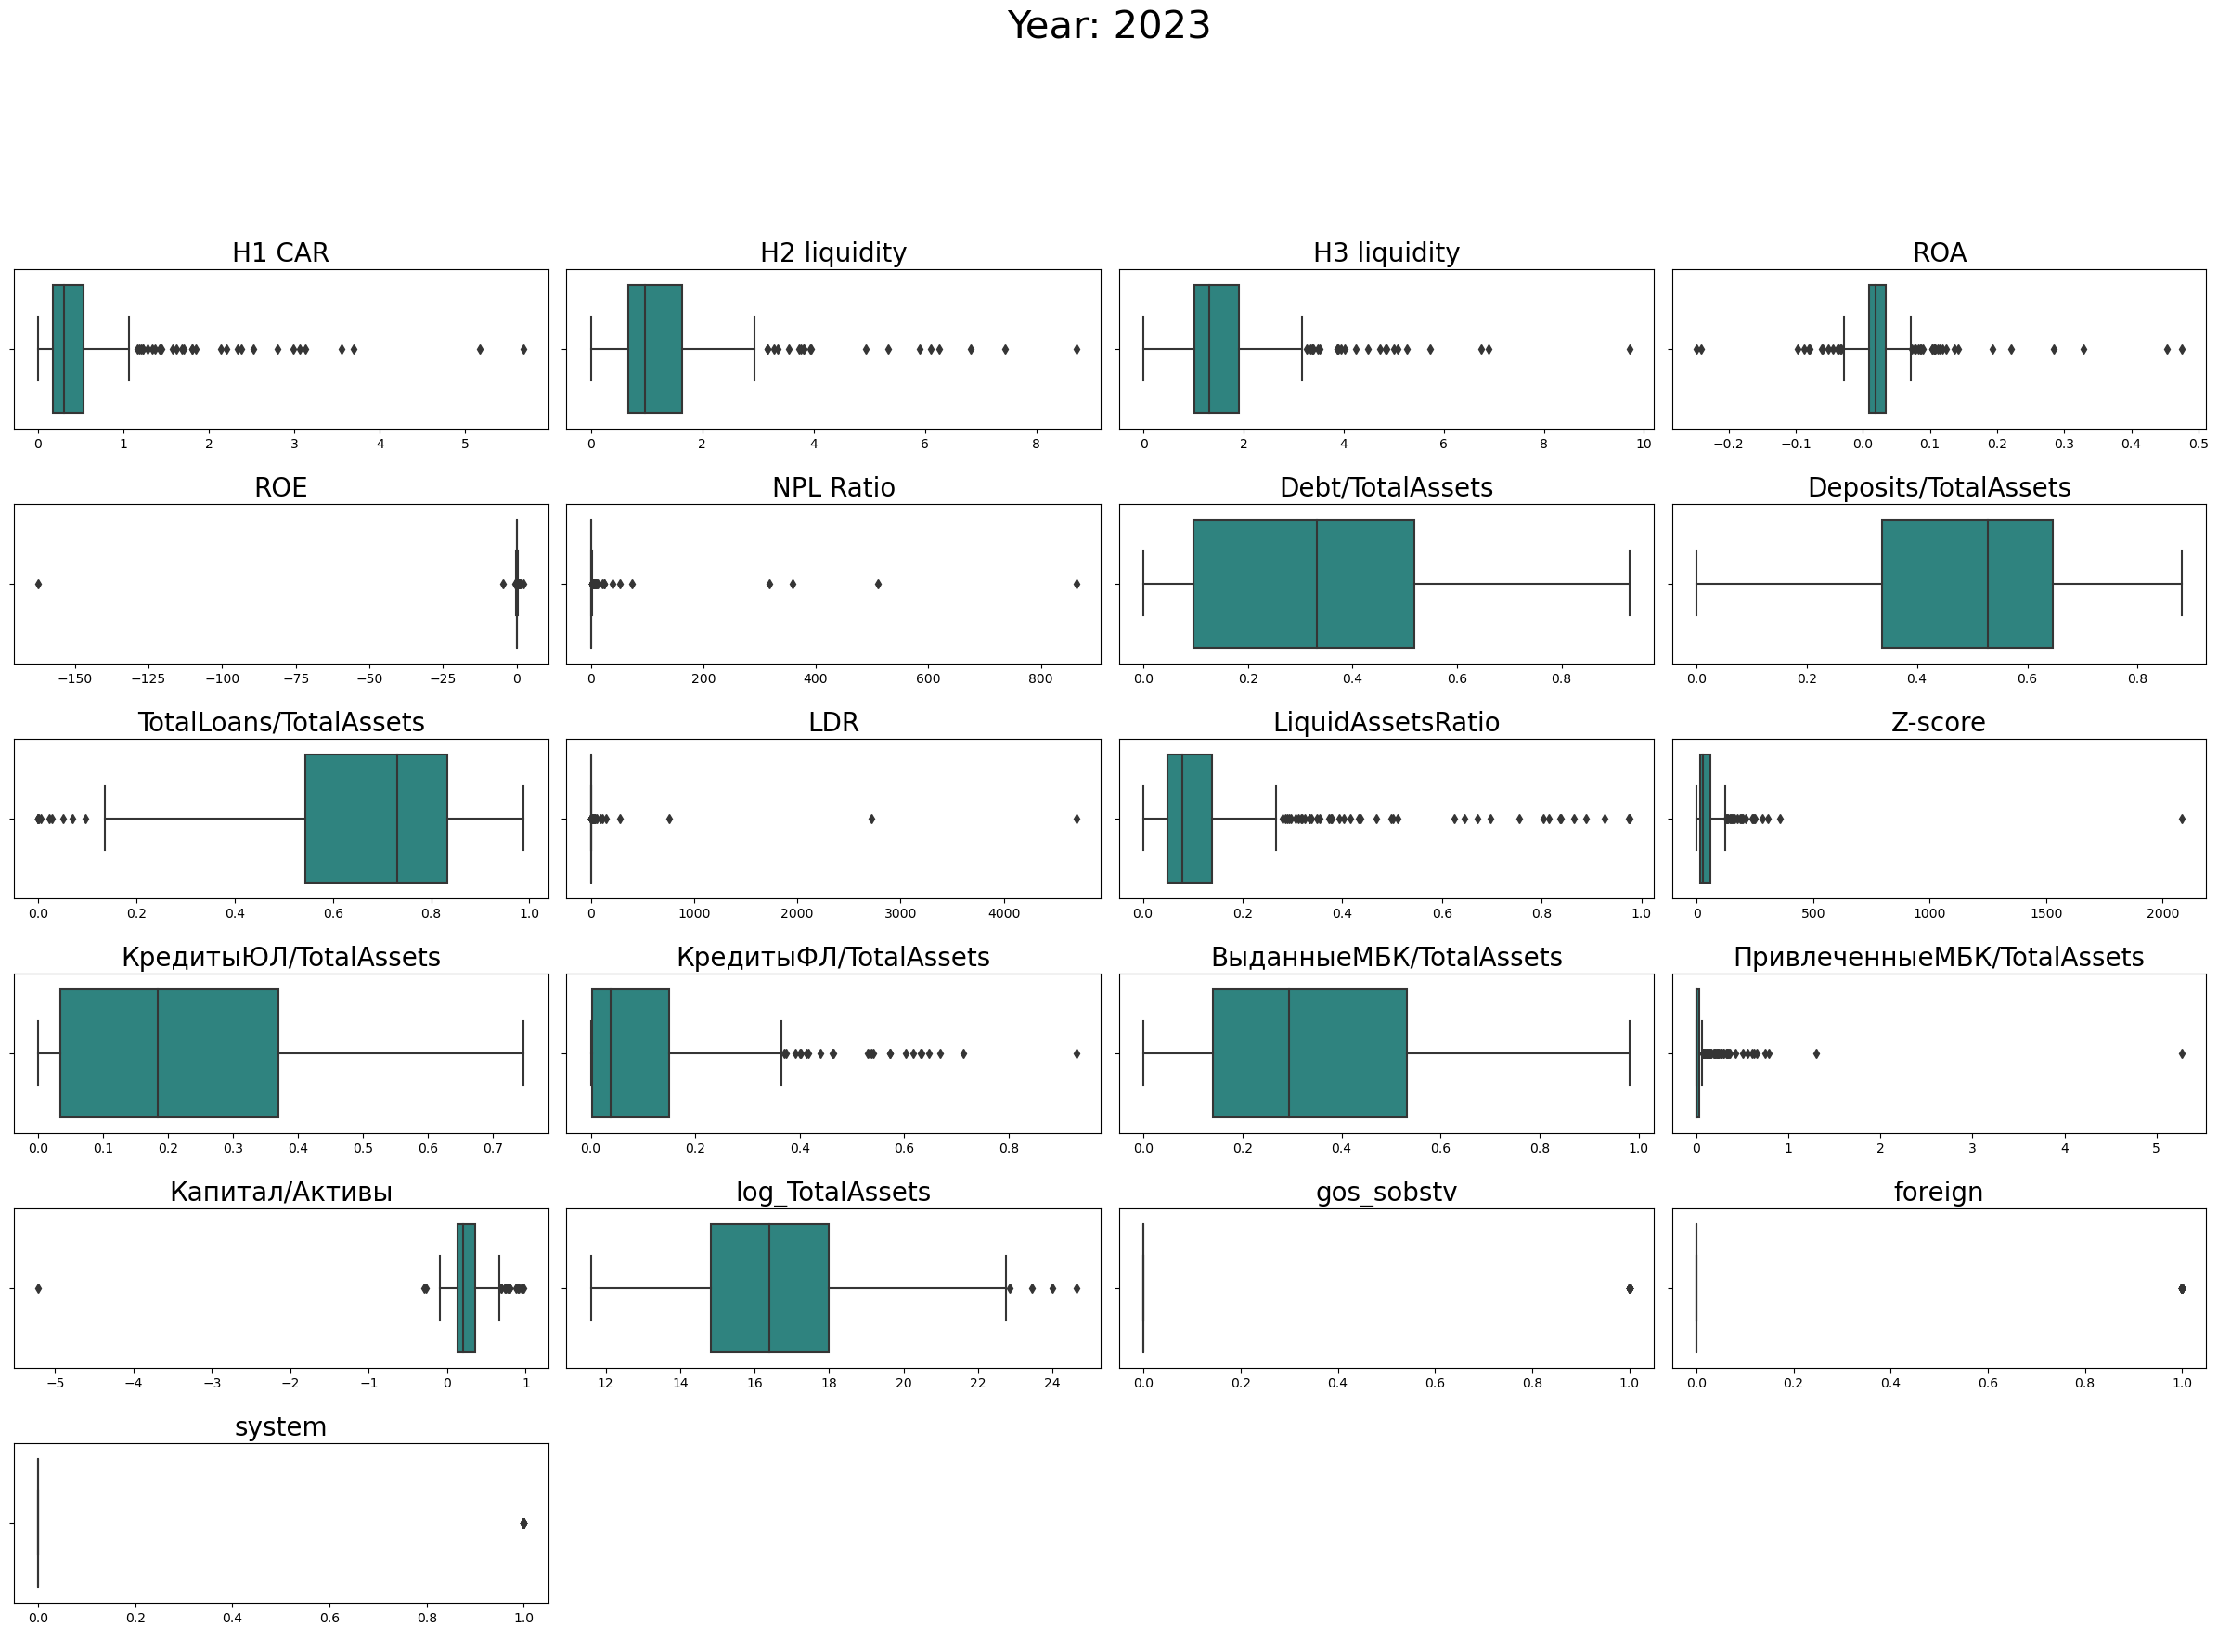

In [99]:
visuals_boxplot(x_2023, year=2023)

- Есть яркие выбросы =>  с ними что-то надо сделать

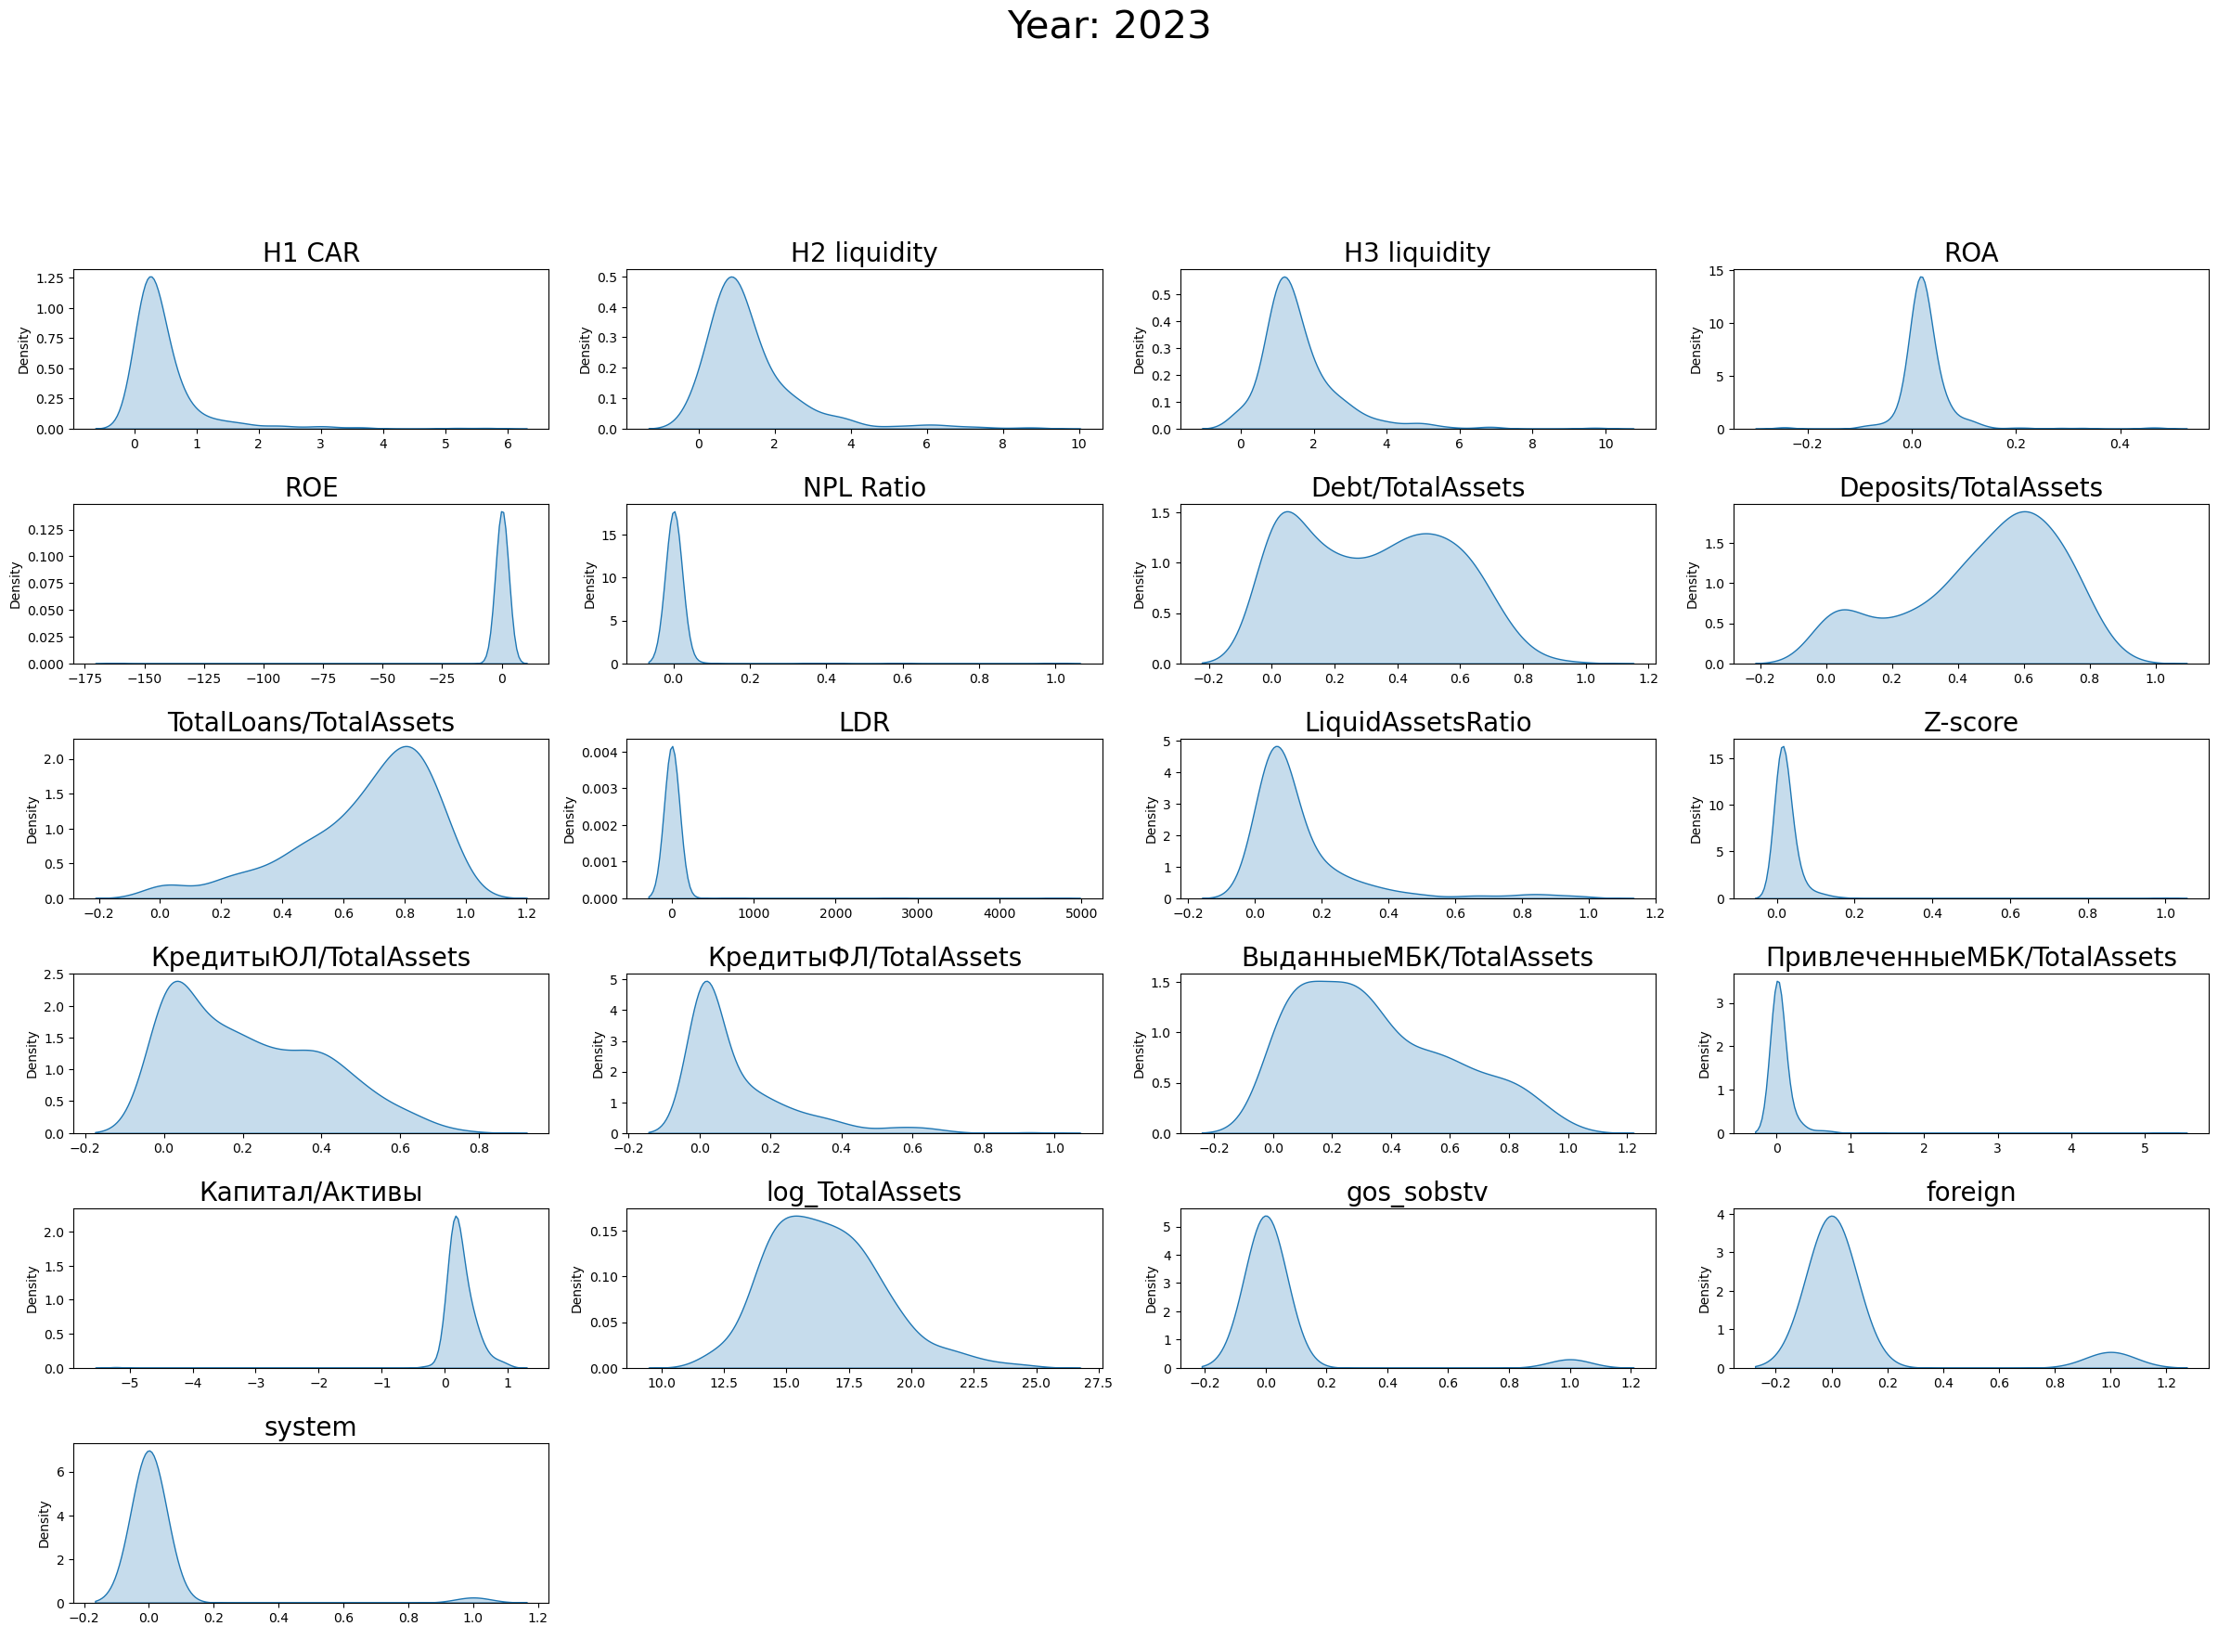

In [167]:
visuals_kdeplot(x_2023, year=2023)

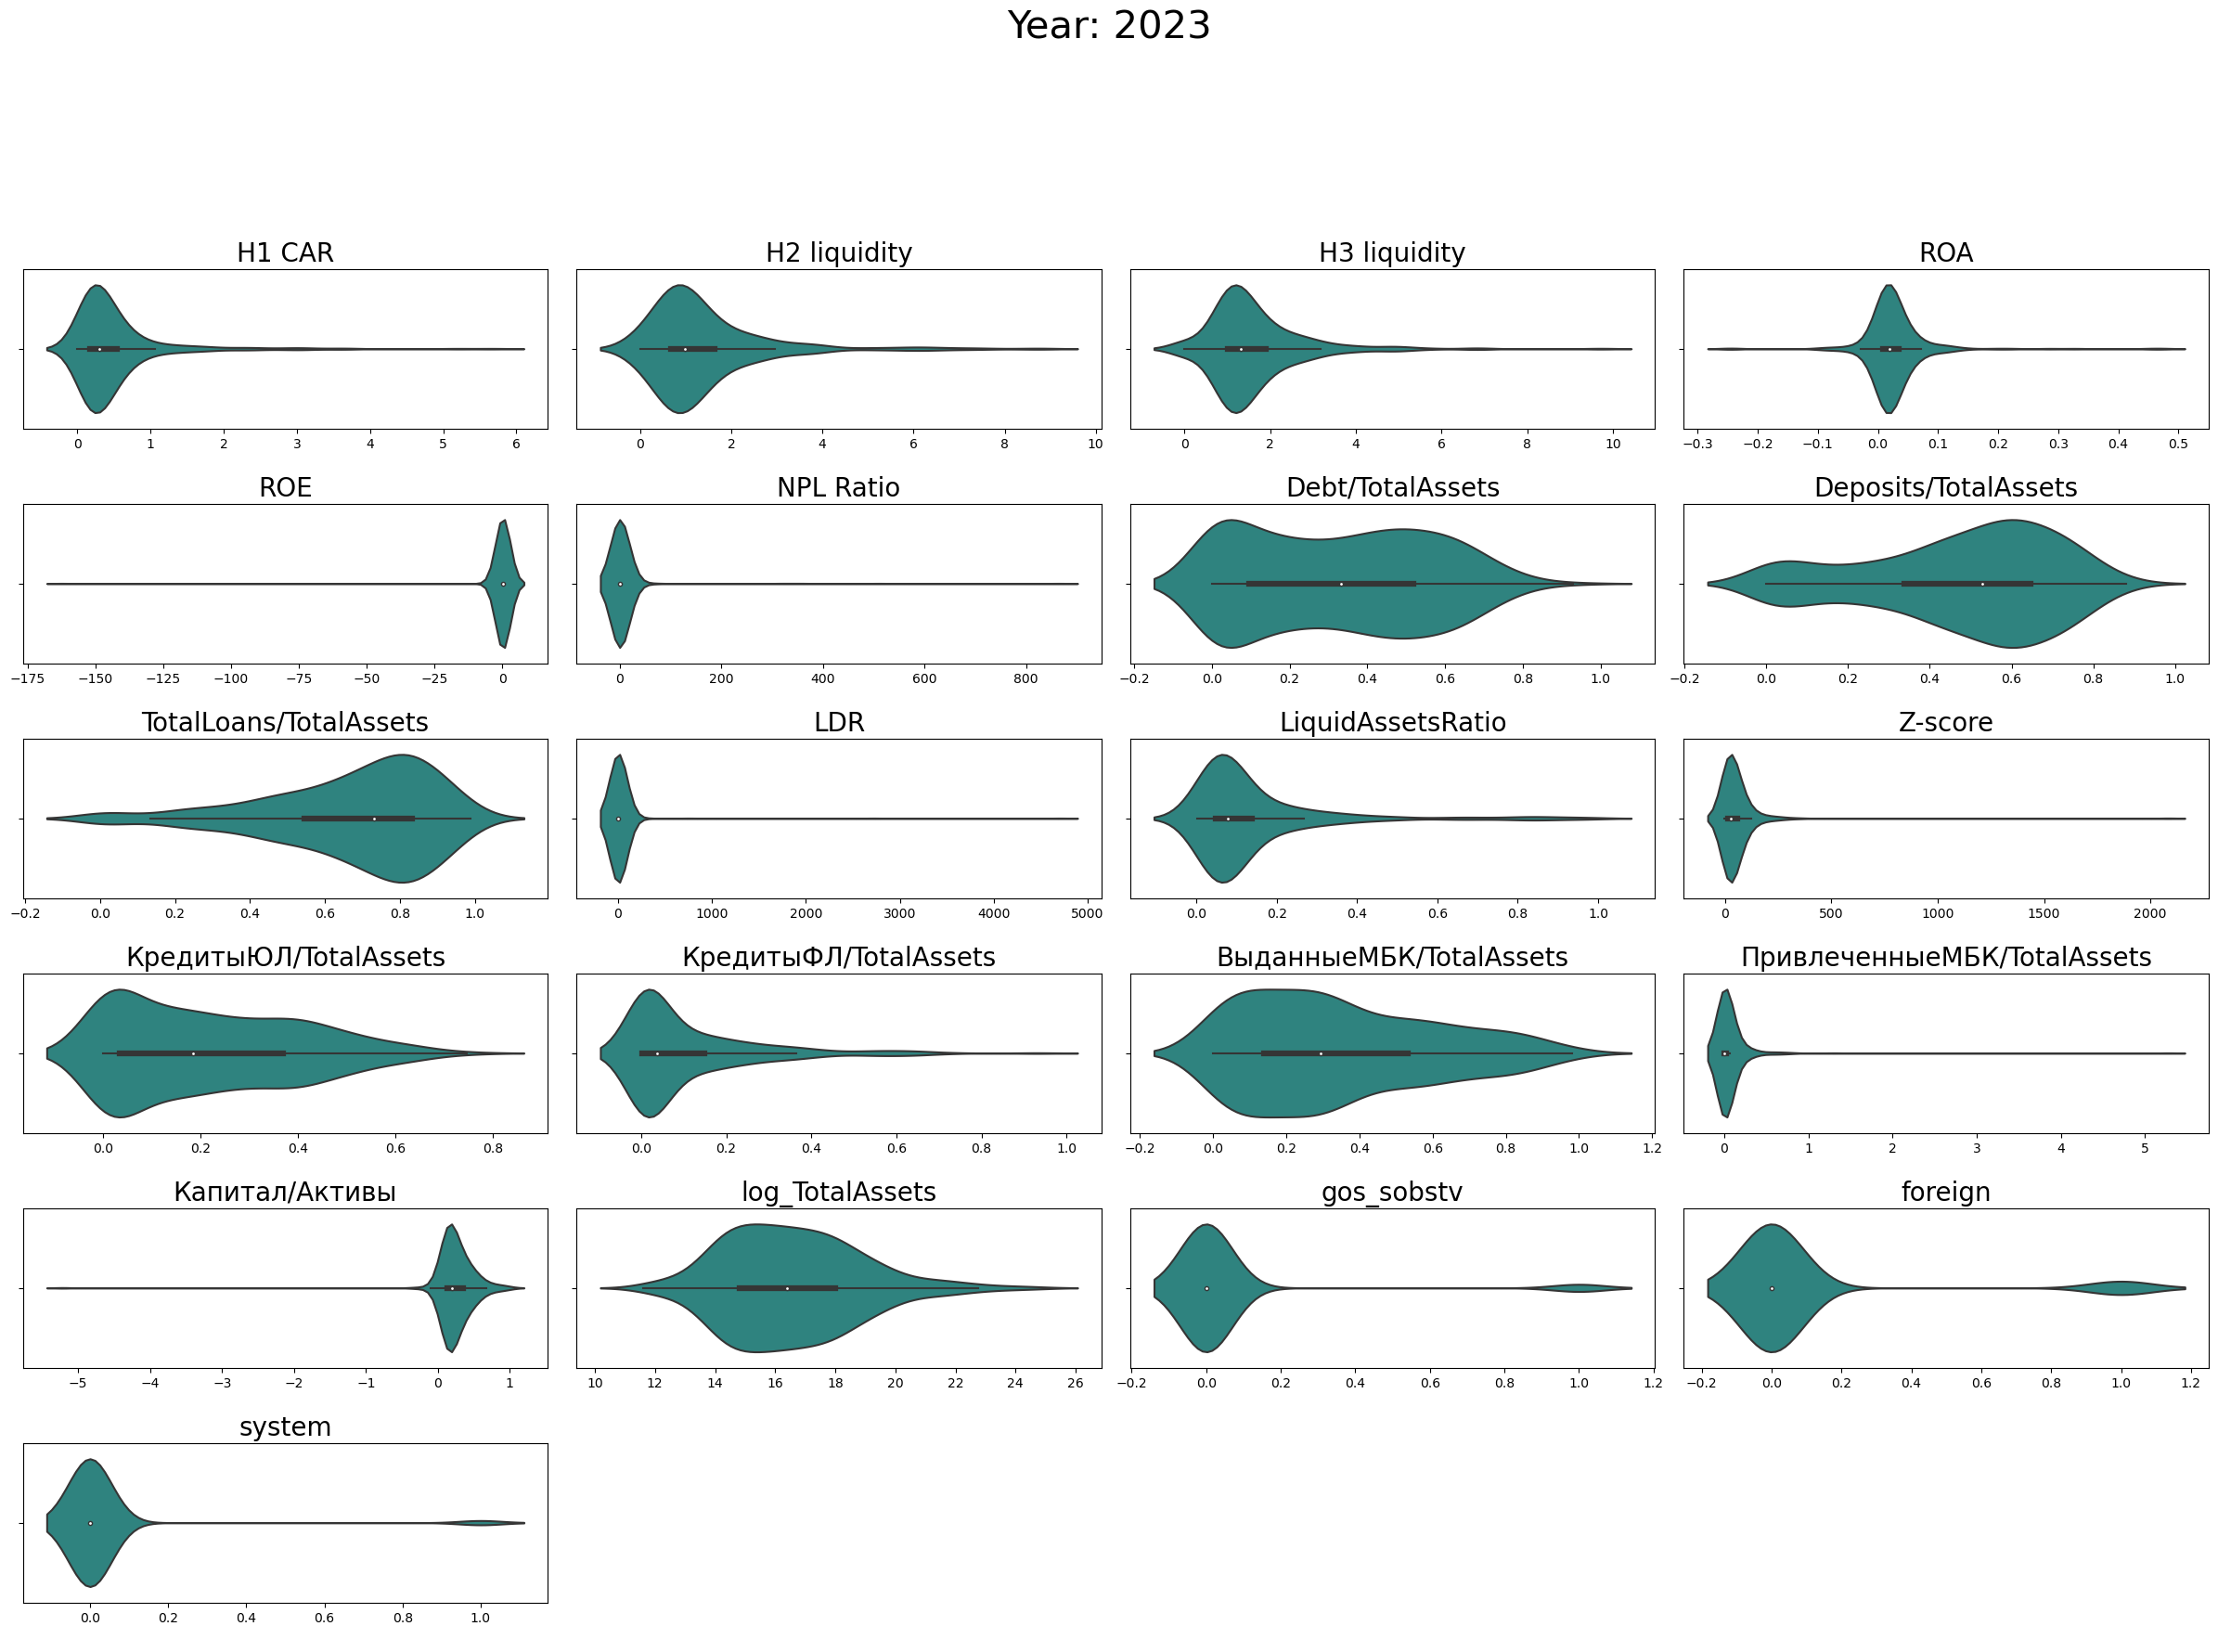

In [101]:
visuals_violinplot(x_2023, year=2023)

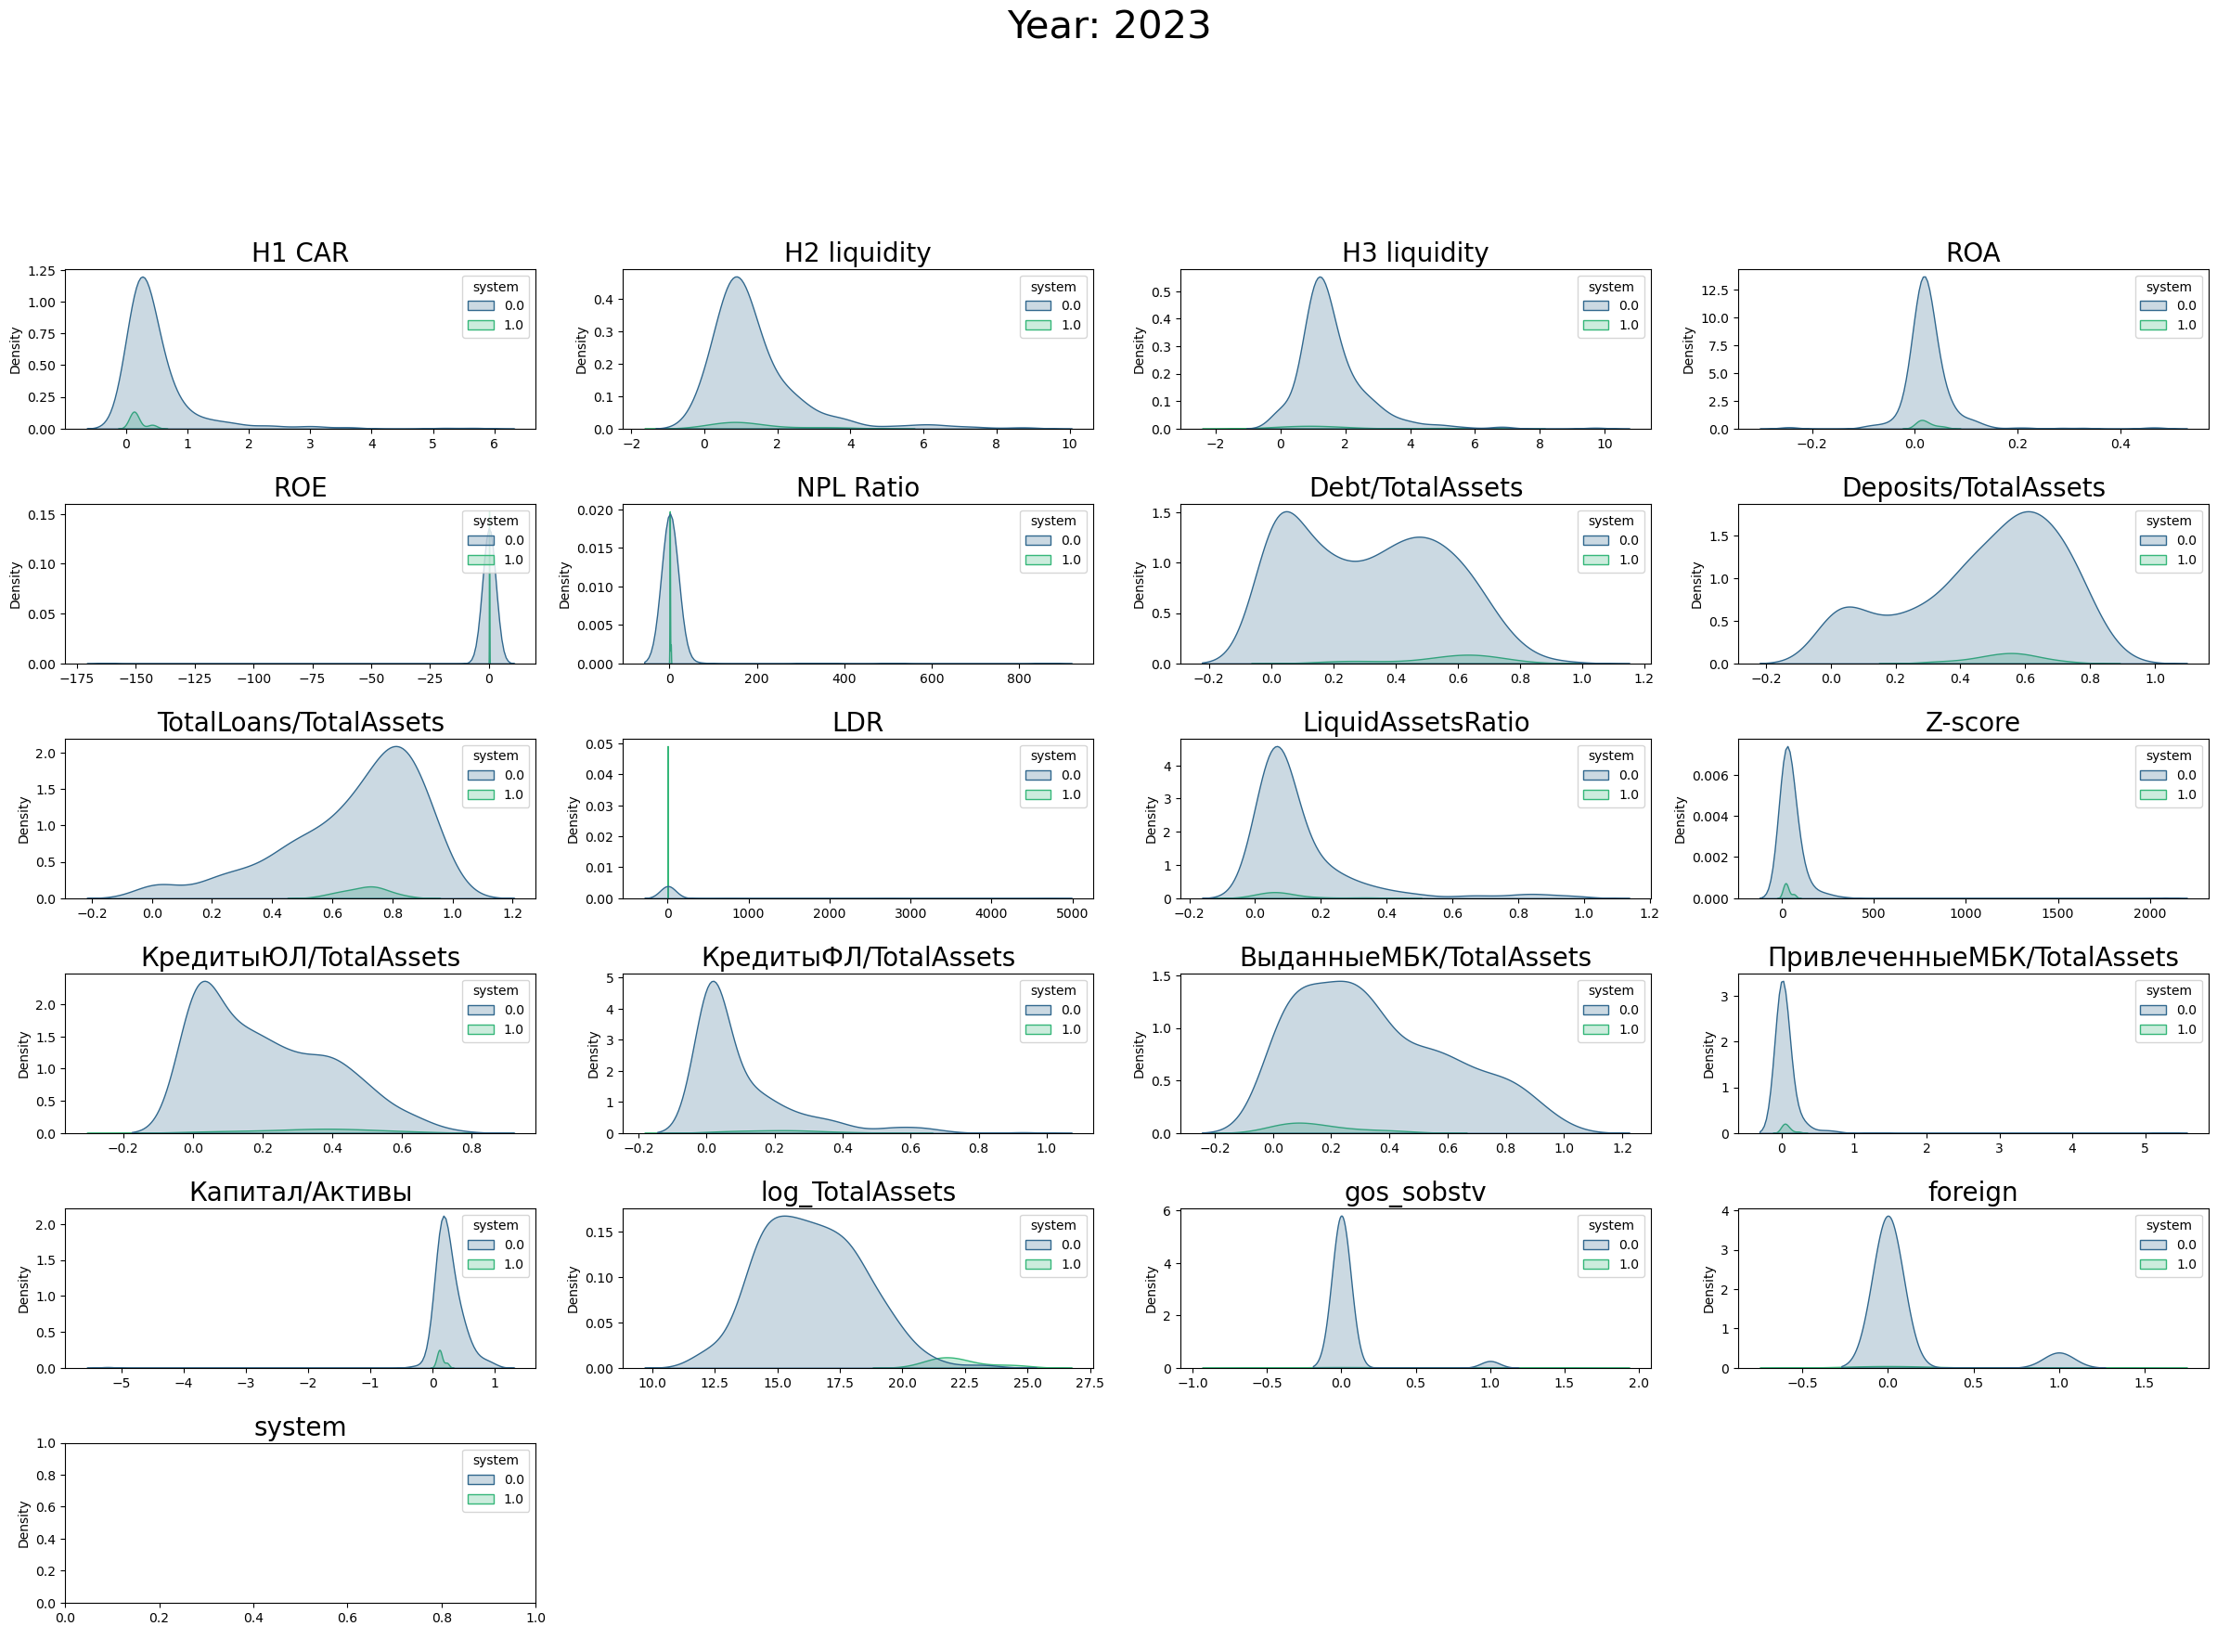

In [102]:
visuals_kdeplot(x_2023, hue= True, hue_col='system', year=2023)

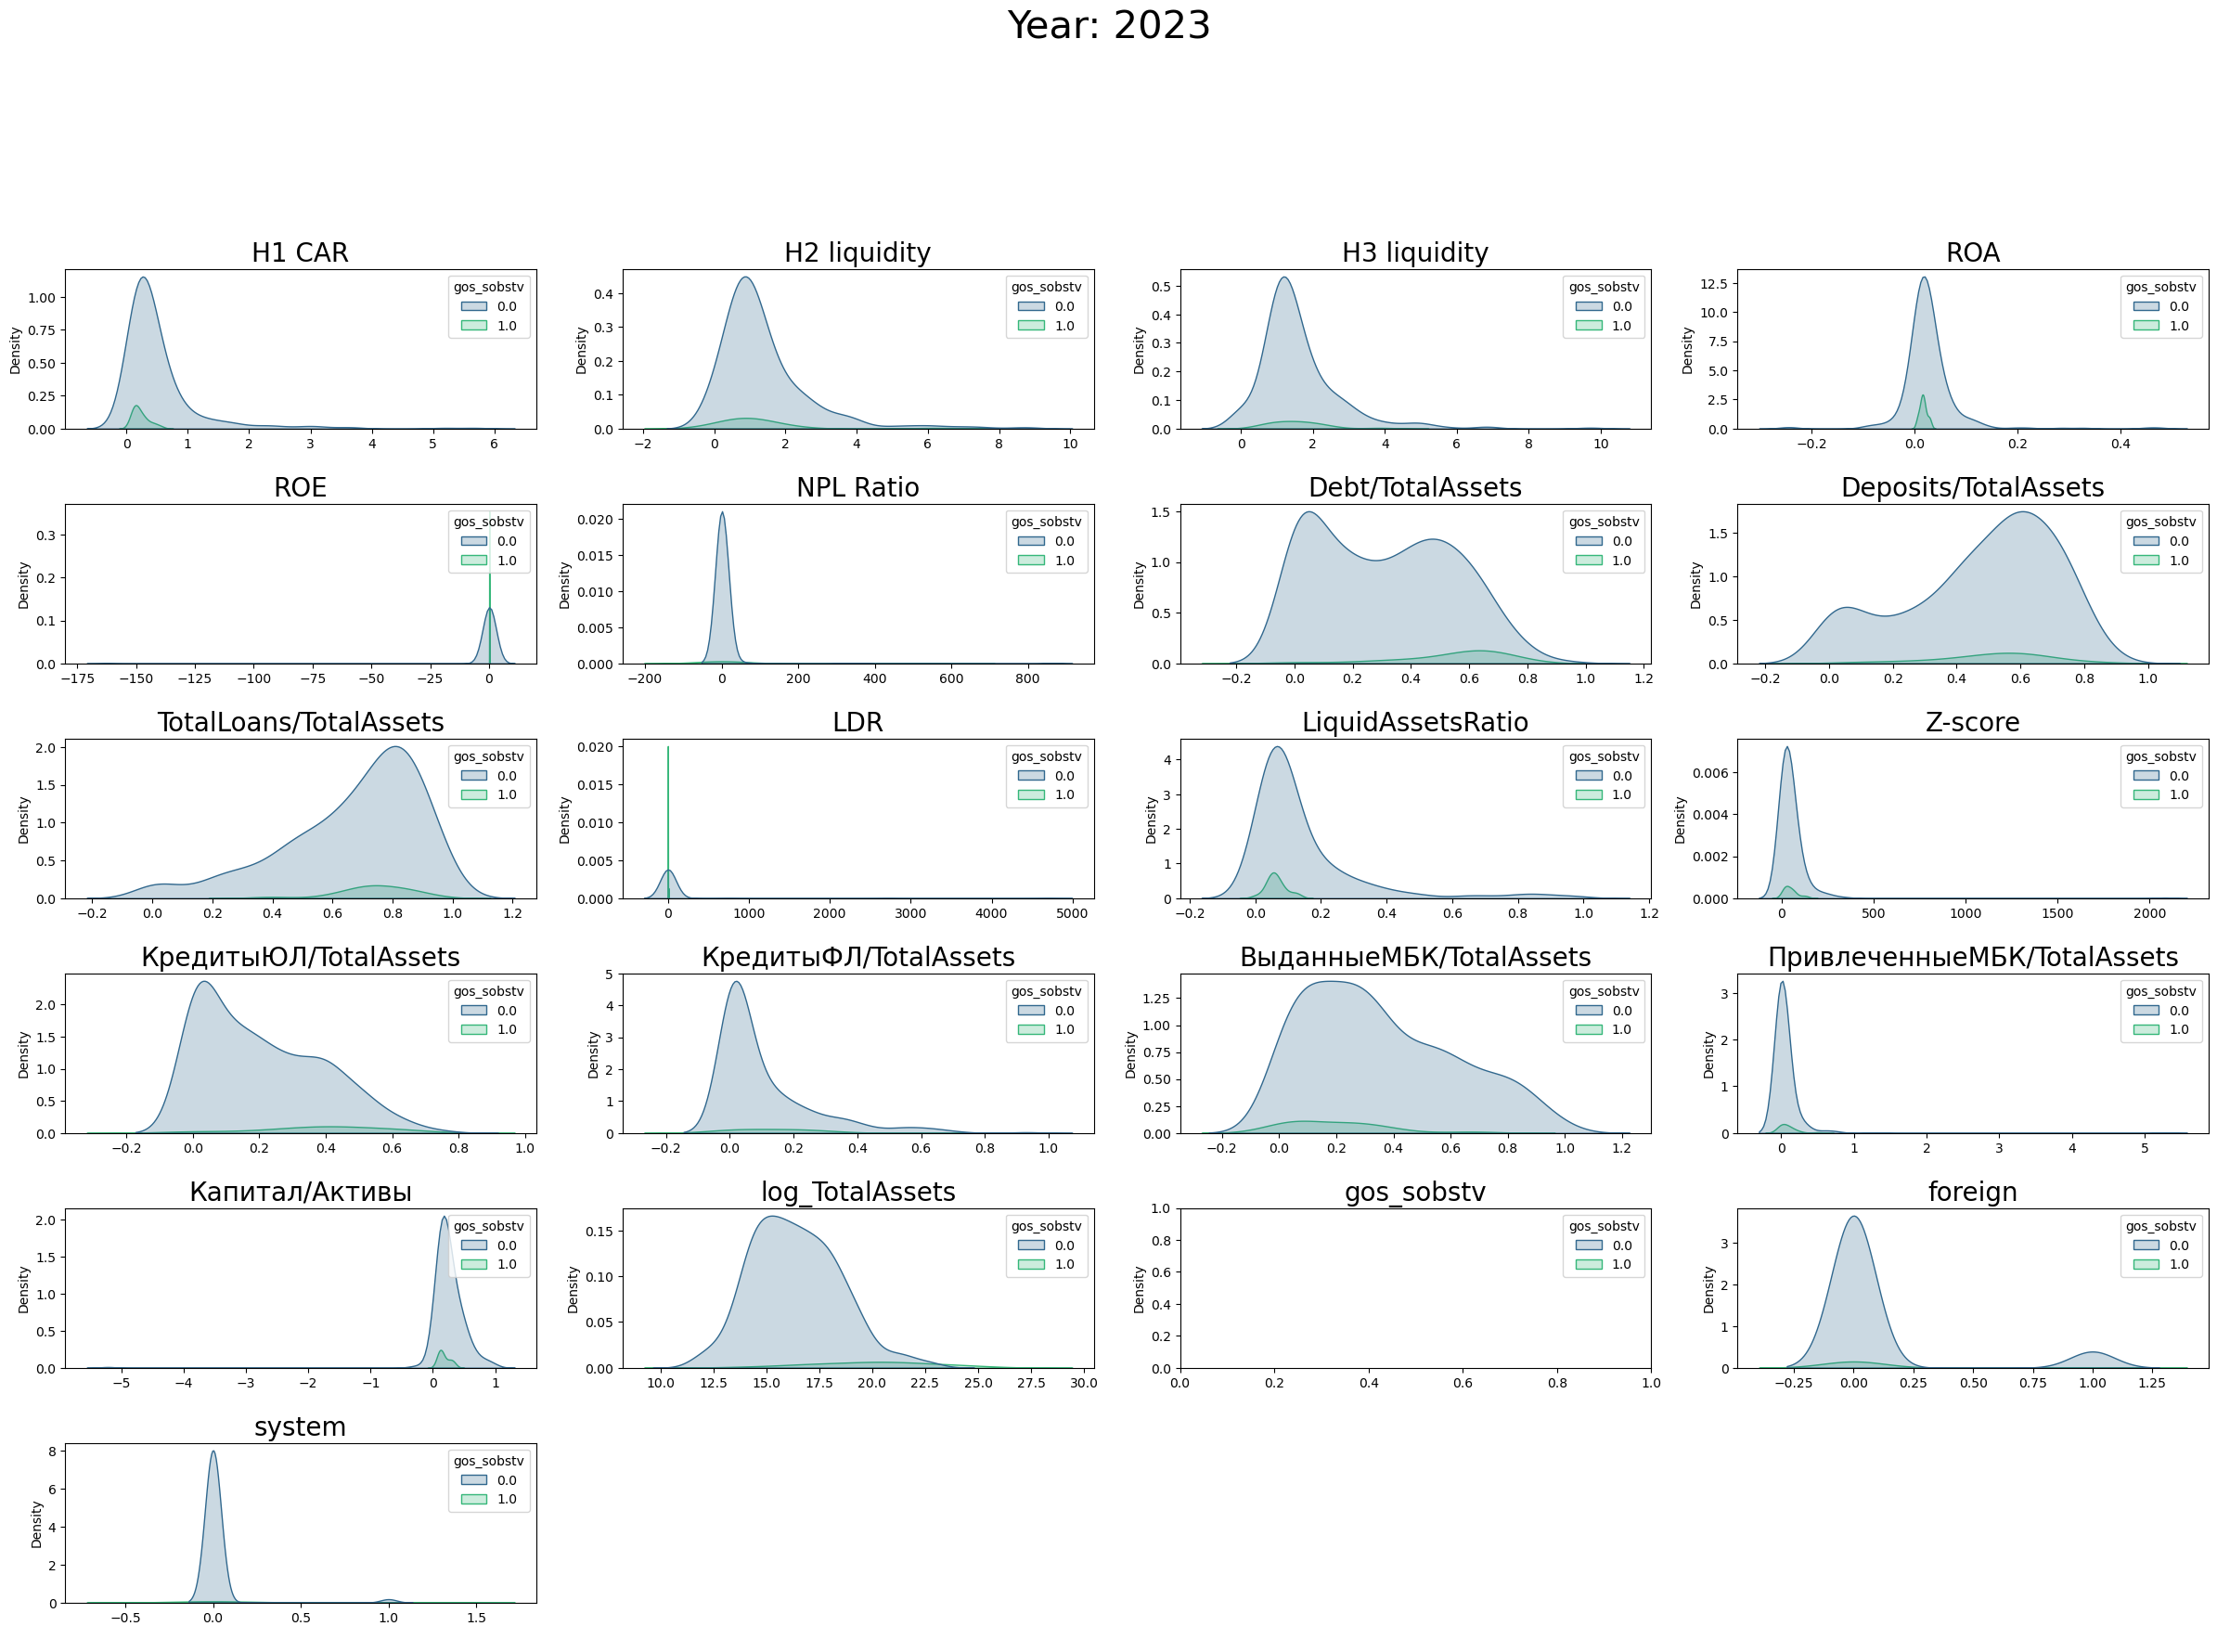

In [103]:
visuals_kdeplot(x_2023, hue= True, hue_col='gos_sobstv', year=2023)

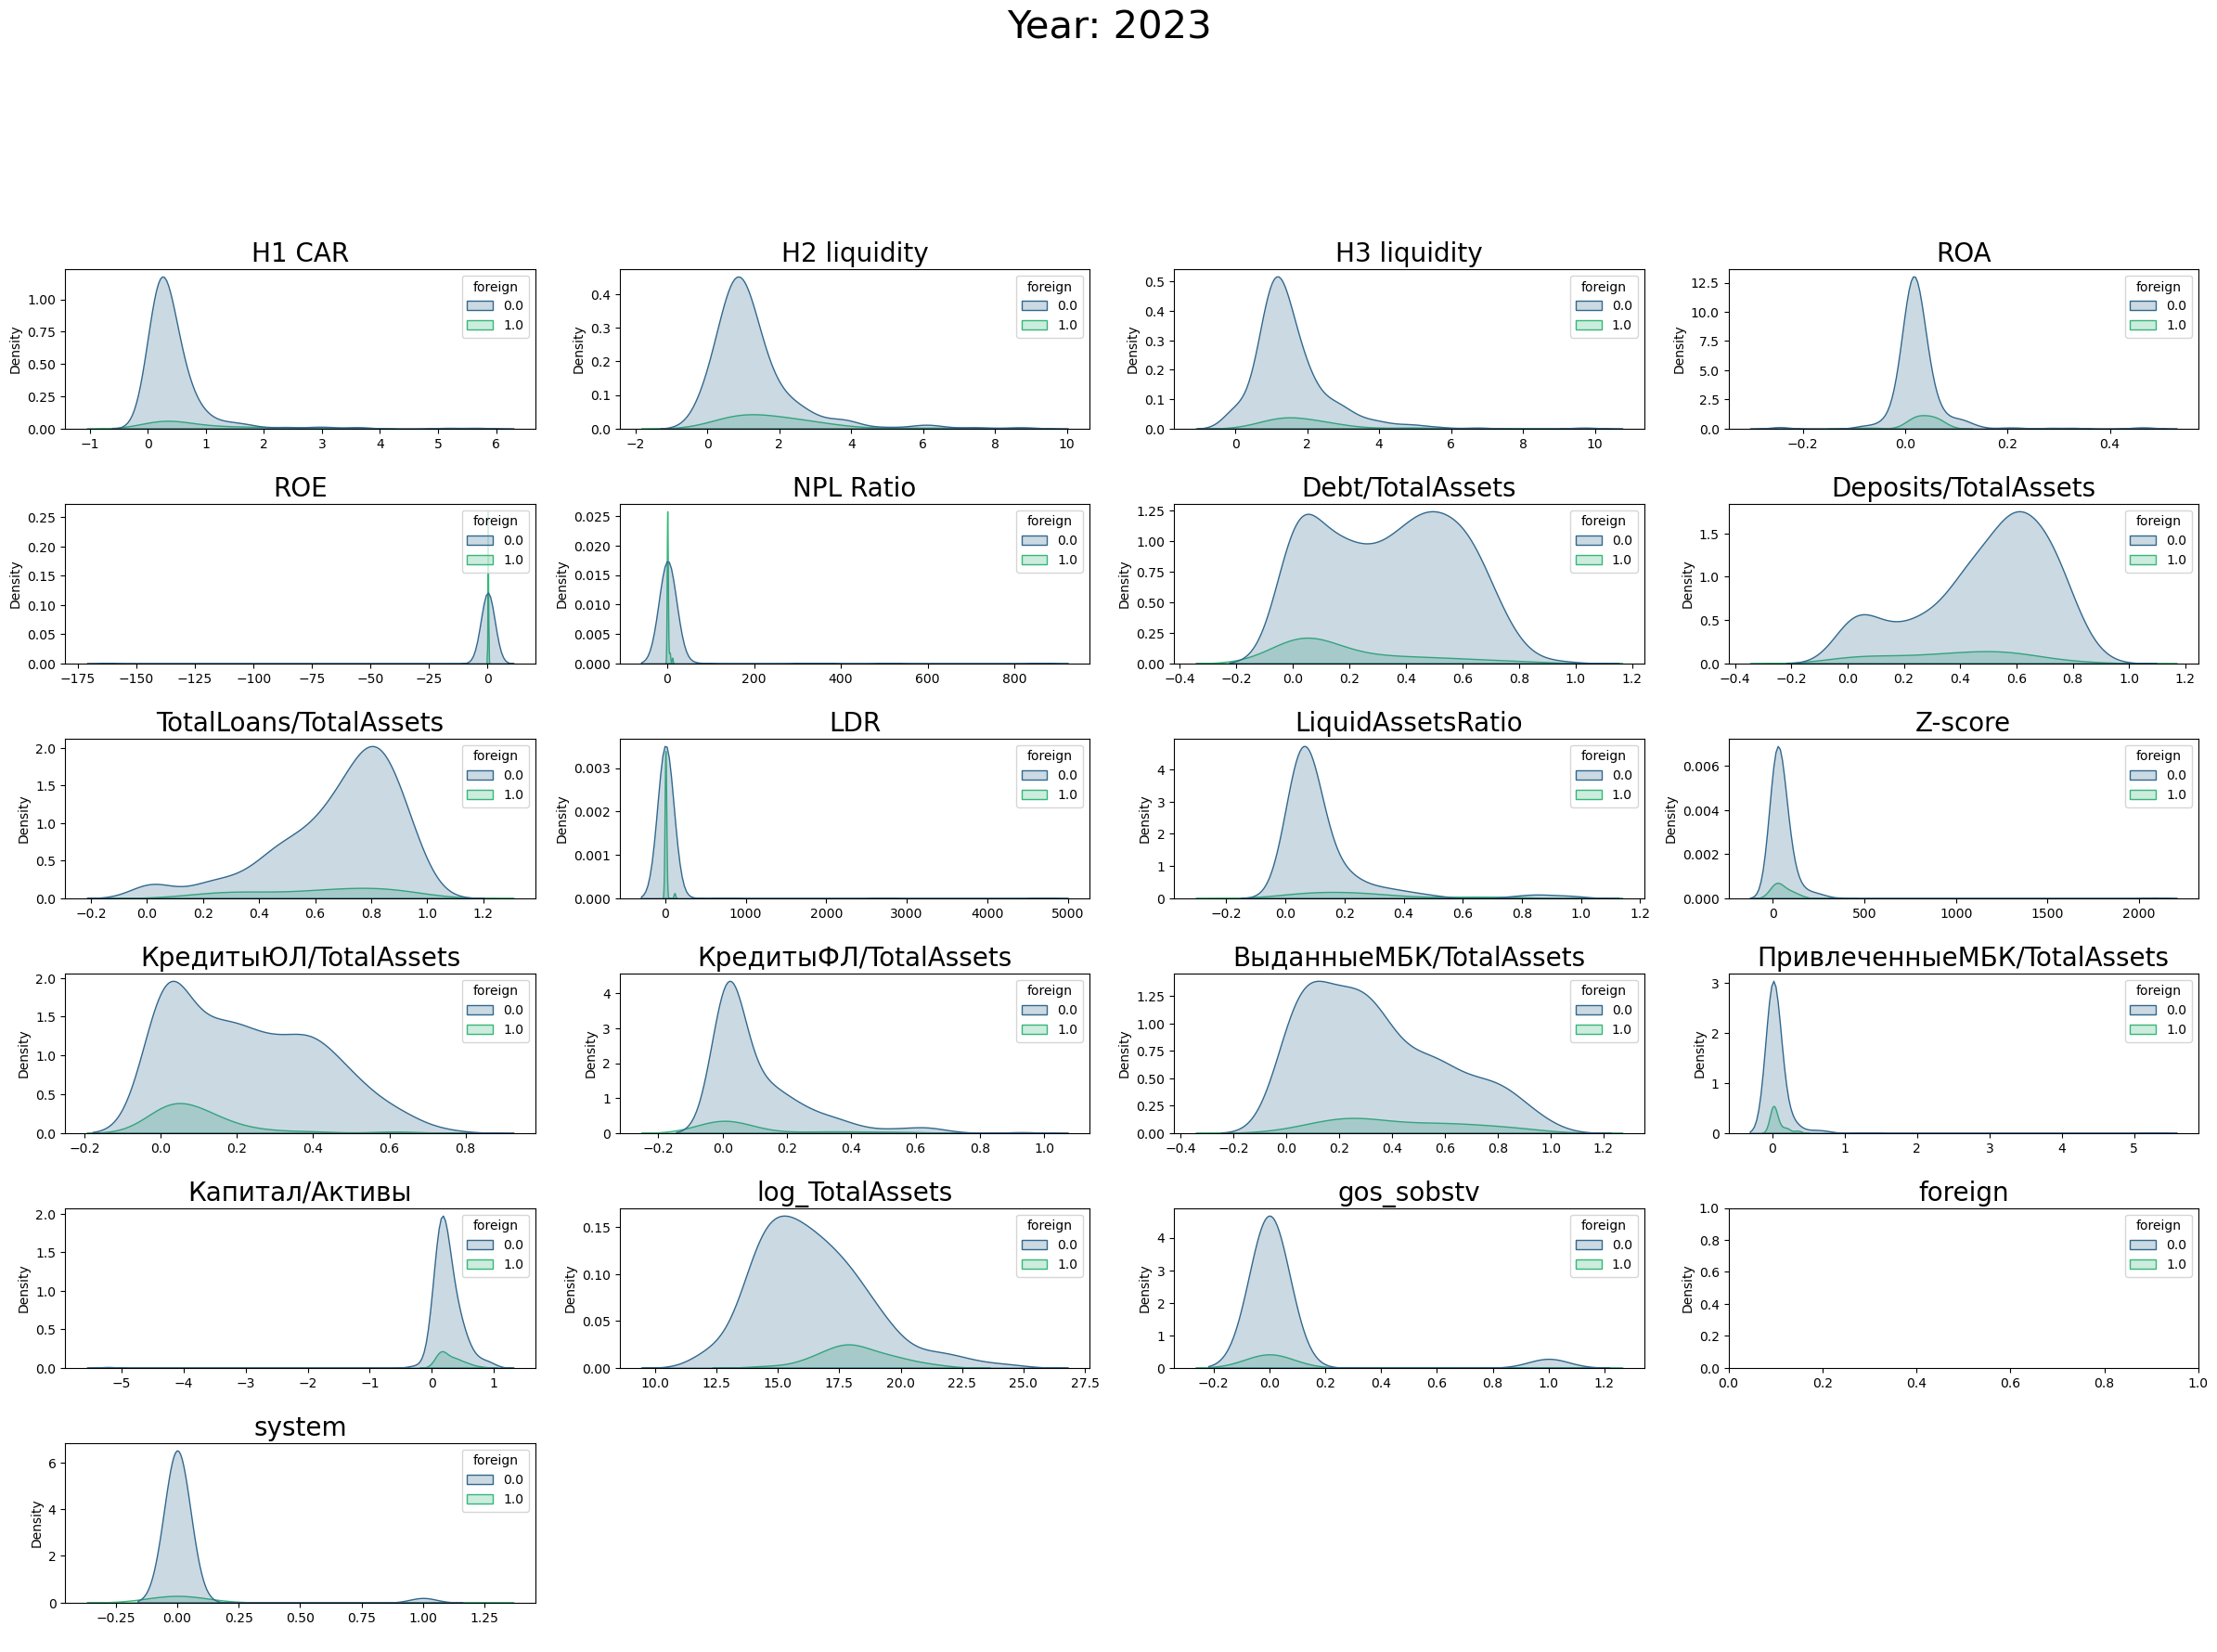

In [104]:
visuals_kdeplot(x_2023, hue= True, hue_col='foreign', year=2023)

In [168]:
def visuals_kdeplot_multiyear(df1, df2, df3, df4, hue = False, hue_col = None):
    plt.figure(figsize=(24,28))
    for i in range(0, df3.shape[1]):
        plt.subplot(10,4,i+1)
         
        sns.kdeplot(x=df1[df1.columns[i]], palette='viridis', shade=True, label='2023')
        sns.kdeplot(x=df2[df2.columns[i]], palette='viridis', shade=True, label='2021')
        sns.kdeplot(x=df3[df3.columns[i]], palette='viridis', shade=True, label='2020')
        sns.kdeplot(x=df4[df4.columns[i]], palette='viridis', shade=True, label='2019')
        plt.legend()
        plt.title(df1.columns[i], fontsize=20)
        plt.xlabel(' ')
        plt.tight_layout()
        plt.suptitle('Межгодовое сравнение', fontsize=30)
        plt.subplots_adjust(top=0.88)

In [18]:
x_2023['LTV'] = None
x_2023['NPL Coverage'] = None
x_2023['NPL/TotalLoans'] = None
x_2023 = x_2023[['Н1 CAR', 'Н2 liquidity', 'Н3 liquidity', 'ROA', 'ROE', 'LTV',
       'NPL Ratio', 'NPL Coverage', 'Debt/TotalAssets', 'Deposits/TotalAssets',
       'TotalLoans/TotalAssets', 'LDR', 'NPL/TotalLoans', 'LiquidAssetsRatio',
       'Z-score', 'КредитыЮЛ/TotalAssets', 'КредитыФЛ/TotalAssets',
       'ВыданныеМБК/TotalAssets', 'ПривлеченныеМБК/TotalAssets',
       'Капитал/Активы', 'log_TotalAssets', 'gos_sobstv', 'foreign', 'system']]

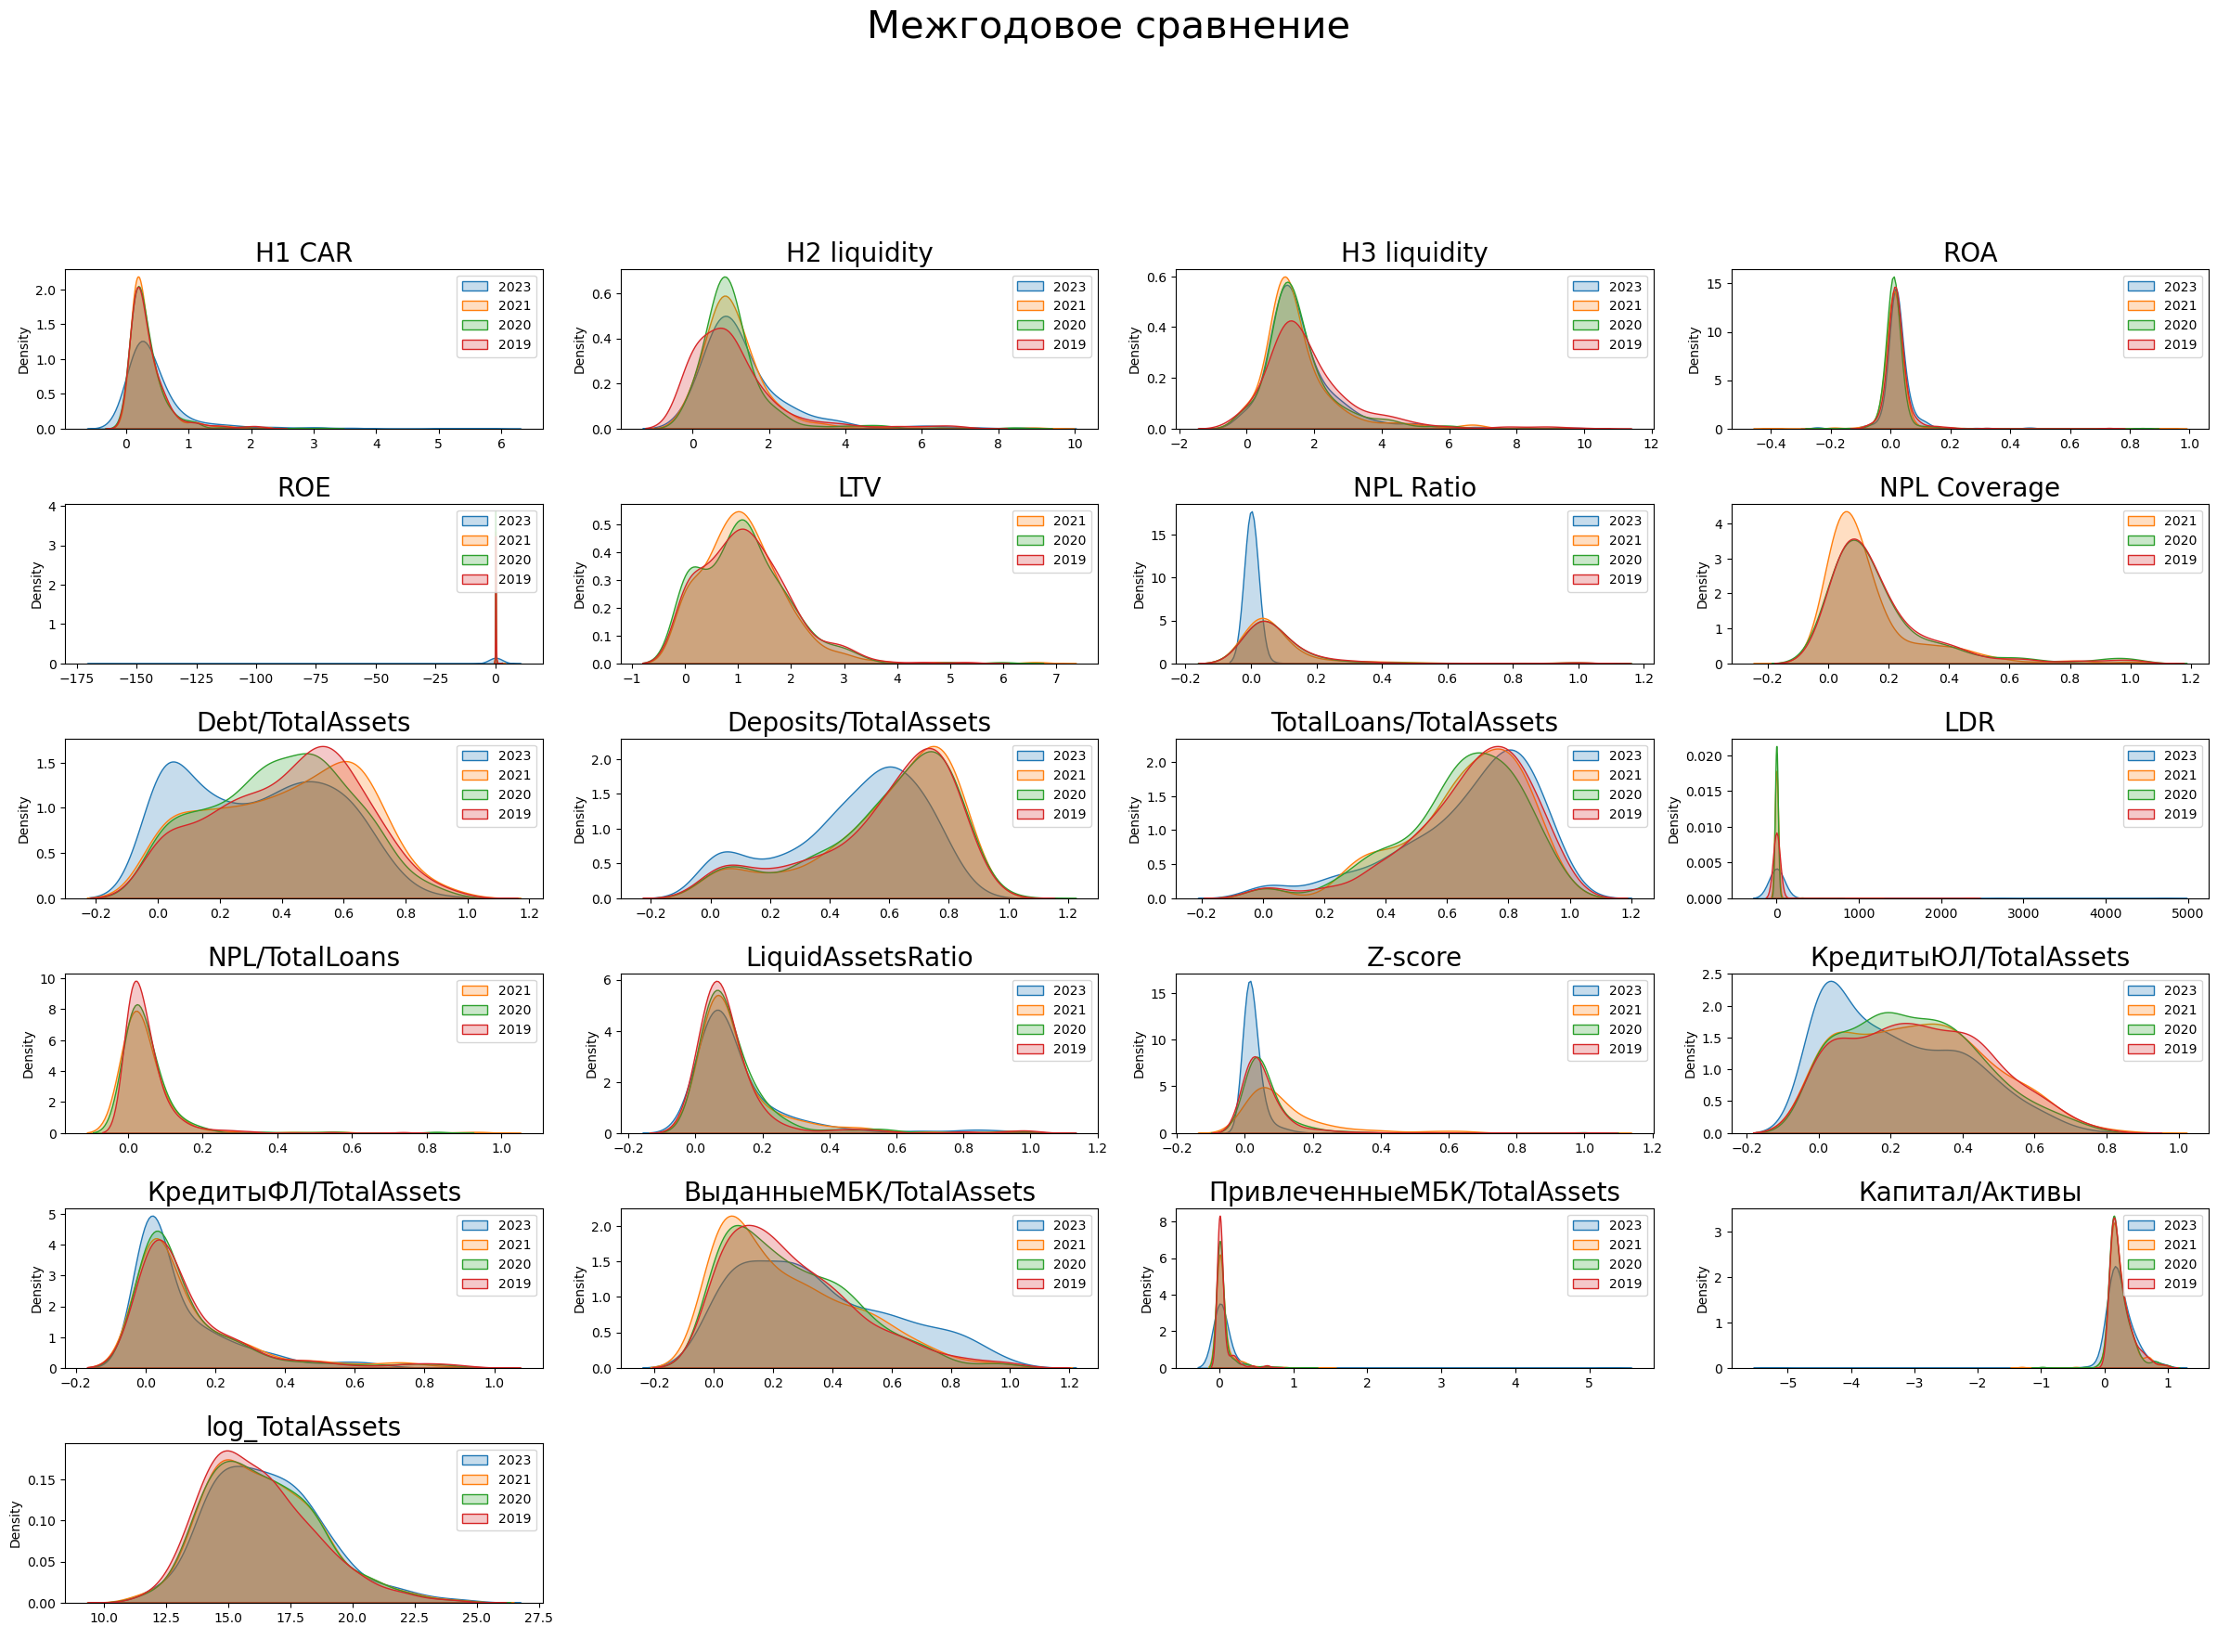

In [170]:
visuals_kdeplot_multiyear(x_2023, x_2021, x_2020, x_2019)

In [156]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_scaled = scaler.fit_transform(x_2023[['Z-score']])

In [20]:
# x_2023[['Z-score', 'Z-score_1']]

In [161]:
feature_scaled

array([[1.80274491e-02],
       [1.08006304e-02],
       [1.15890581e-02],
       [5.88731090e-03],
       [9.19074417e-03],
       [2.95786457e-02],
       [1.40042723e-02],
       [6.79859482e-03],
       [8.56615064e-03],
       [3.36862496e-02],
       [1.27045925e-02],
       [5.51144278e-03],
       [3.25336343e-02],
       [1.45674609e-02],
       [9.10492857e-03],
       [2.88599417e-02],
       [3.14567063e-02],
       [1.22540893e-02],
       [1.27397543e-02],
       [5.55355295e-02],
       [5.70068523e-02],
       [8.11147772e-03],
       [6.75476187e-03],
       [8.15603462e-03],
       [2.50926369e-03],
       [6.06080163e-03],
       [1.50822547e-02],
       [6.71948653e-03],
       [6.15326391e-03],
       [9.70622932e-03],
       [1.94435751e-03],
       [6.72009745e-03],
       [1.02444755e-02],
       [4.86256803e-03],
       [1.40946840e-02],
       [4.60616551e-03],
       [9.15866735e-03],
       [1.01293129e-01],
       [5.00687913e-03],
       [1.04041932e-03],


In [162]:
x_2023['Z-score'] = feature_scaled

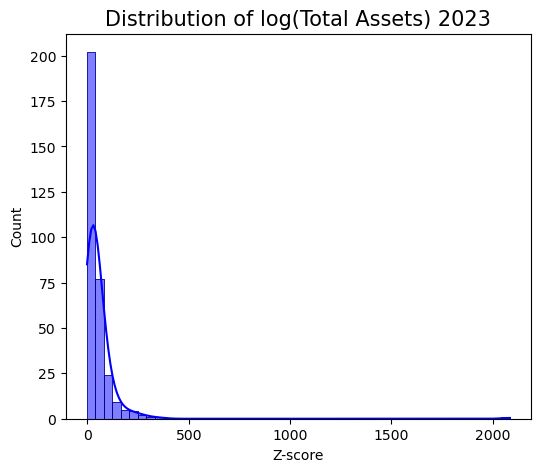

In [68]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Distribution of log(Total Assets) 2023', fontsize=15)
sns.histplot(x_2023['Z-score'],
             bins=50,
             ax=ax,
             color='blue',
             edgecolor='darkblue',
             kde = True);

In [69]:
# print('Наибольшее кол-во TA лежит в интервале:', np.exp(13), '-',np.exp(17))
# print('Среднее значение цены',x_2023['log_TotalAssets'].mean())

In [66]:
# for column in X.columns:
#     fig, ax = plt.subplots(figsize=(6, 5))
#     ax.set_title(f'Distribution of {column} 2019', fontsize=15)
#     sns.histplot(X[column],        #np.log1p(X['Z-score']),
#                 bins=50,
#                 ax=ax,
#                 color='blue',
#                 edgecolor='darkblue',
#                 kde = True);

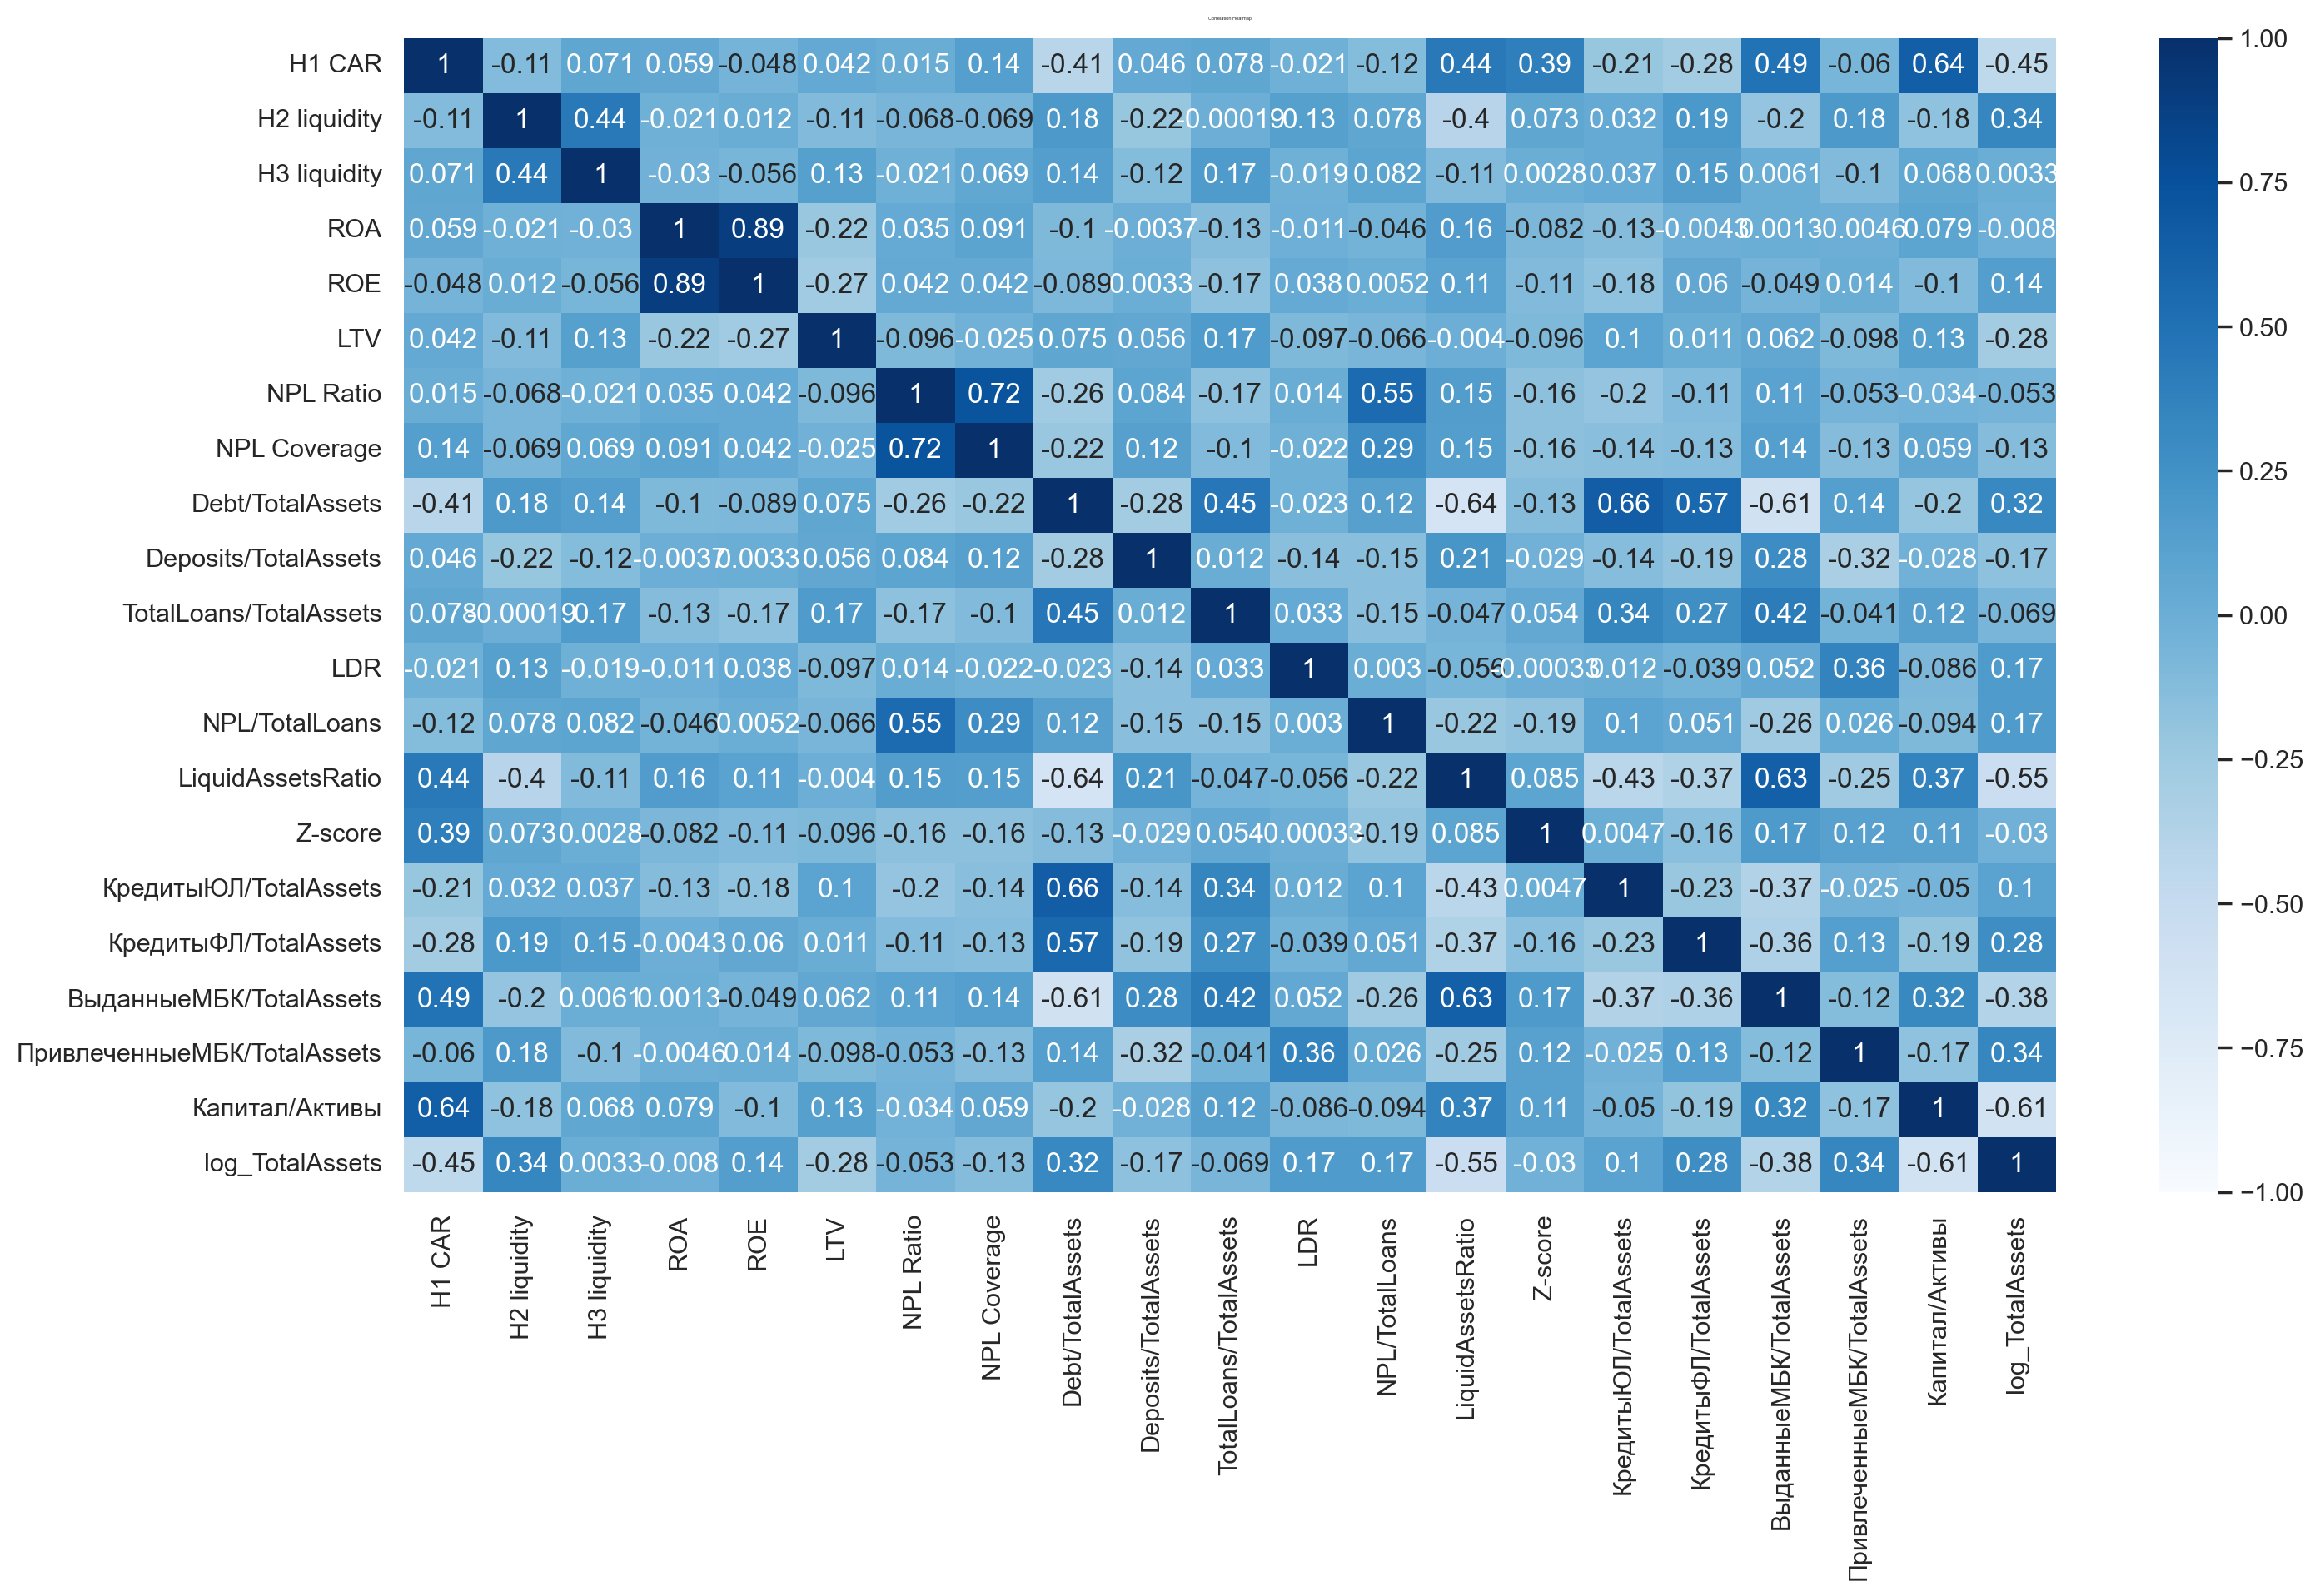

In [39]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':2}, pad=8);

### K-means

In [21]:
from clustering_functions import knn_nan_inputer

x_2023_knn = knn_nan_inputer(x_2023)
x_2021_knn = knn_nan_inputer(x_2021)
x_2020_knn = knn_nan_inputer(x_2020)
x_2019_knn = knn_nan_inputer(x_2019)

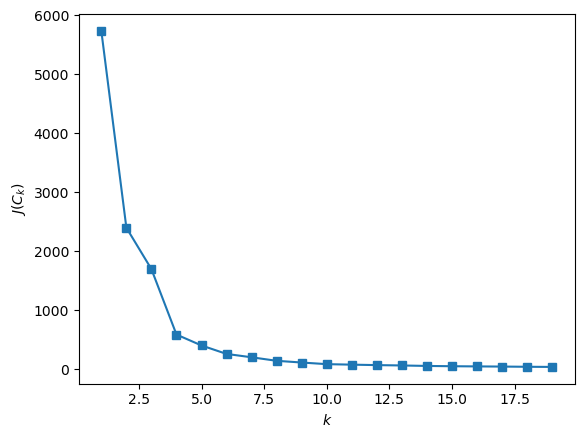

In [22]:
rg = range(1, 20)
inertia = []
for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=4).fit(x_2023_knn)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(rg, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Локтя особо не видно - непонятно, сколько брать кластеров

In [399]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X_2019, 
                          num_clusters = [10], 
                          bank_name_column = df_2019['bank_name'], 
                          scaling = False,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                             clustering_before_dimreduce = False,
                          perplexity=6 #for tsne
                         )
k_means.k_means_clustering()

silhouette_score: 0.55040604


In [390]:
k_means.compute_cluster_stats(list_index = 0, cluster_index = 9)

In [141]:
k_means = KMeans(n_clusters = 3)
k_means = k_means.fit(X1)
labels = k_means.predict(X1)

In [142]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 290, 1: 1, 2: 18}

In [163]:
unique, counts = np.unique(labels, return_counts=True)

In [164]:
unique

array([0, 1, 2])

### DBSCAN

In [45]:
df=df.drop(columns='log_TotalAssets')

In [46]:
imputer = KNNImputer(n_neighbors=2, missing_values = np.nan, weights = 'distance')
df1 = imputer.fit_transform(df)

In [47]:
pd.DataFrame(df1)

0       1         2       3       4         5         6         7   \
0    0.141800  1.1311  1.120500  0.0350  0.2576  1.087300  0.024500  0.046000   
1    0.112500  0.9263  0.932500  0.0143  0.1486  0.339600  0.029000  0.055200   
2    0.120400  0.6827  1.044700  0.0168  0.1624  0.883400  0.019100  0.037200   
3    0.142100  0.9278  1.099900  0.0271  0.2082  0.519700  0.036600  0.053900   
4    0.175900  1.2119  0.803300  0.0090  0.0934  0.226900  0.020500  0.028500   
..        ...     ...       ...     ...     ...       ...       ...       ...   
325  0.332600  0.0000  0.000000 -0.1326 -0.3936  6.604400  0.000000 -0.088300   
326  1.303800  0.0000  0.000000 -0.0103 -0.0219  1.444700  1.000000  1.000000   
327  2.213200  0.0000  0.000000  0.0091  0.0129  1.194548  0.079471  0.088312   
328  0.935000  0.0000  0.000000  0.0591  0.0714  0.768310  0.016175  0.023026   
329  1.679739  0.0000  3.739472  0.0012  0.0012  1.723099  0.086411  0.271795   

           8         9   ...        13          14        15        16  \
0    0.726954  0.235899  ...  0.076863   41.028539  0.417084  0.264566   
1    0.613859  0.278135  ...  0.035238   21.177745  0.397477  0.204934   
2    0.655300  0.273232  ...  0.049651   23.809017  0.572677  0.082616   
3    0.652261  0.450415  ...  0.123794   17.358945  0.437211  0.215050   
4    0.784963  0.125694  ...  0.016596   21.338680  0.727299  0.048010   
..        ...       ...  ...       ...         ...       ...       ...   
325  0.030466  0.526209  ...  0.622945    3.300615  0.000000  0.030466   
326  0.133038  0.375323  ...  0.746171   70.160635  0.041218  0.091820   
327  0.000000  0.002581  ...  0.000305  103.593973  0.000000  0.000000   
328  0.000000  0.080899  ...  0.768494   52.812762  0.000000  0.000000   
329  0.000000  0.000000  ...  0.997229  154.686354  0.000000  0.000000   

           17        18        19   20   21   22  
0    0.041275  0.056874  0.130655  1.0  0.0  1.0  
1    0.047756  0.059954  0.093301  1.0  0.0  1.0  
2    0.077276  0.027967  0.099463  1.0  0.0  0.0  
3    0.133636  0.031224  0.126357  0.0  0.0  1.0  
4    0.036681  0.227464  0.101536  0.0  0.0  1.0  
..        ...       ...       ...  ...  ...  ...  
325  0.539224  0.000000  0.230442  0.0  0.0  0.0  
326  0.663830  0.000000  0.476884  0.0  0.0  0.0  
327  0.000000  0.000000  0.857054  0.0  0.0  0.0  
328  0.627199  0.000000  0.735043  0.0  0.0  0.0  
329  0.996309  0.000000  0.996915  0.0  0.0  0.0  

[330 rows x 23 columns]

In [56]:
X = df1

In [57]:
dbscan = DBSCAN(eps=40, min_samples=3)
clustering = dbscan.fit(X)
labels = clustering.labels_
sample_cores=np.zeros_like(labels,dtype=bool)
sample_cores[clustering.core_sample_indices_]=True
n_clusters=len(set(labels))- (1 if -1 in labels else 0)
print('No of clusters:',n_clusters)

No of clusters: 2


In [58]:
# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
eps = 1
eps_history = [eps]

while outlier_percentage > 0.1:    
    model = DBSCAN(eps=eps, min_samples=3).fit(X)
    
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 1
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)

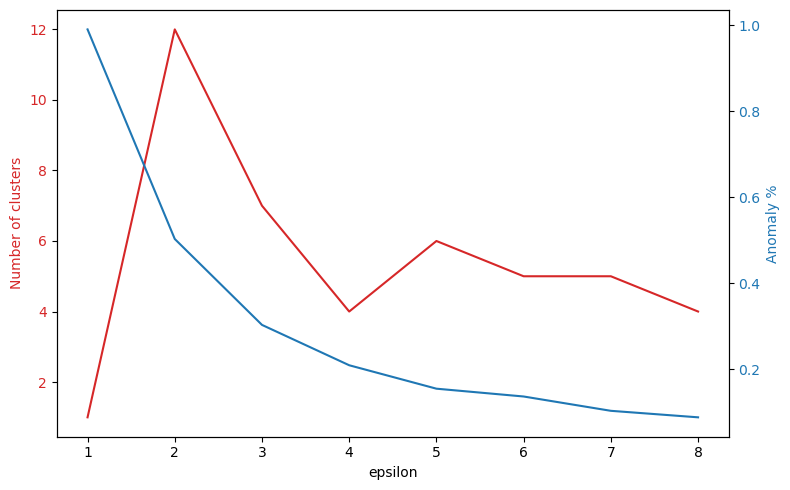

In [59]:
iterations = eps_history[:-1]

fig, ax1 = plt.subplots(figsize=(8,5))
color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('Number of clusters', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # инициализация второй оси в соотвествии с размером первой

color = 'tab:blue'
ax2.set_ylabel('Anomaly %', color=color)
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

In [60]:
dbscan = DBSCAN(eps=5, min_samples=3)
clustering = dbscan.fit(X)
labels = clustering.labels_
sample_cores=np.zeros_like(labels,dtype=bool)
sample_cores[clustering.core_sample_indices_]=True
n_clusters=len(set(labels))- (1 if -1 in labels else 0)
print('No of clusters:',n_clusters)

No of clusters: 6


In [61]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{-1: 51, 0: 258, 1: 5, 2: 4, 3: 3, 4: 5, 5: 4}

In [62]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [63]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=labels)
fig.show()

In [68]:
df_2021['bank_name']

0                             Сбербанк
1                                  ВТБ
2                          Газпромбанк
3                           Альфа-Банк
4      Московский кредитный банк (МКБ)
                    ...               
325                               Нода
326                    Промсвязьинвест
327    «Петербургский Расчетный Центр»
328                   «Дальний Восток»
329                            «ИНЭКО»
Name: bank_name, Length: 330, dtype: object

In [69]:
df_2021['labels'] = labels

In [70]:
df_2021['labels'].value_counts().keys()

Index([0, -1, 1, 4, 2, 5, 3], dtype='int64', name='labels')

In [74]:
i=0
print(df_2021[df_2021['bank_name'].isin(df_2021[df_2021['labels'] == i]['bank_name'].values)]['bank_name'].values)
df_2021[df_2021['bank_name'].isin(df_2021[df_2021['labels'] == i]['bank_name'].values)].describe()

['Сбербанк' 'ВТБ' 'Газпромбанк' 'Альфа-Банк'
 'Московский кредитный банк (МКБ)' 'Банк «Открытие»' 'Совкомбанк'
 'Банк ДОМ.РФ' 'Росбанк' 'Тинькофф Банк' 'Банк «РОССИЯ»' 'ЮниКредит Банк'
 'Банк «Санкт-Петербург»' 'Ак Барс Банк' 'Новикомбанк' 'Уралсиб'
 'Почта Банк' 'Ситибанк' 'АКБ «БЭНК ОФ ЧАЙНА»' 'МТС Банк' 'РНКБ'
 'АйСиБиСи Банк' 'Уральский банк реконструкции и развития (УБРиР)'
 'ОТП Банк' 'Банк ТКБ' 'Банк ЗЕНИТ' 'Хоум Банк' 'Абсолют Банк' 'Экспобанк'
 'ББР Банк' 'Русский Стандарт' 'Азиатско-Тихоокеанский банк (АТБ)'
 'Кредит Европа Банк' 'Металлинвестбанк' 'Банк Синара (СКБ-банк)'
 'Инвестторгбанк' '«Кубань Кредит»' 'Локо-Банк' 'Ингосстрах Банк'
 'Газэнергобанк' 'Банк Интеза' 'Примсоцбанк' 'Авангард' 'БКС Банк'
 'Банк «Центр-инвест»' 'Банк «Левобережный»' 'МЕТКОМБАНК' 'СПБ Банк'
 'ИНГ Банк' 'Сургутнефтегазбанк' 'Национальный Резервный Банк'
 'Банк «Солидарность»' 'СДМ-Банк' 'Банк МФК' 'Фора-Банк' 'КИВИ Банк'
 'Банк «Приморье»' 'Челиндбанк' 'Модульбанк' 'Банк «ЦентроКредит»'
 'СЕВЕРГА

Вложения в ценные бумаги  Кредитный портфель  \
count              1.840000e+02        2.510000e+02   
mean               7.530018e+07        2.521112e+08   
std                4.484136e+08        1.879641e+09   
min                0.000000e+00        0.000000e+00   
25%                5.525242e+05        8.655680e+05   
50%                3.560637e+06        3.550172e+06   
75%                1.444387e+07        1.826042e+07   
max                5.173248e+09        2.645656e+10   

       Просроченная задолженность в кредитном портфеле  Активы нетто  \
count                                     2.440000e+02  2.580000e+02   
mean                                      8.932519e+06  3.907936e+08   
std                                       5.071258e+07  2.784429e+09   
min                                       0.000000e+00  1.217120e+05   
25%                                       3.590450e+04  2.701040e+06   
50%                                       2.085775e+05  9.985940e+06   
75%                                       1.053456e+06  5.012496e+07   
max                                       6.599235e+08  3.881254e+10   

       Бумаги переданные в РЕПО       Векселя  Вклады физических лиц  \
count              2.580000e+02  2.580000e+02           2.580000e+02   
mean               1.001755e+07  8.085312e+05           1.165611e+08   
std                1.110120e+08  5.379290e+06           9.719670e+08   
min                0.000000e+00  0.000000e+00           0.000000e+00   
25%                0.000000e+00  0.000000e+00           3.070502e+05   
50%                0.000000e+00  0.000000e+00           2.313688e+06   
75%                0.000000e+00  6.408750e+04           1.334694e+07   
max                1.758385e+09  7.086333e+07           1.468500e+10   

       Вклады физических лиц оборот  Вложения в акции  Вложения в векселя  \
count                  2.580000e+02      2.580000e+02        2.580000e+02   
mean                   9.839219e+07      1.438388e+06        3.780013e+04   
std                    8.776384e+08      9.221555e+06        3.289601e+05   
min                    0.000000e+00      0.000000e+00        0.000000e+00   
25%                    1.605768e+05      0.000000e+00        0.000000e+00   
50%                    8.123345e+05      0.000000e+00        0.000000e+00   
75%                    5.530203e+06      2.778825e+04        0.000000e+00   
max                    1.316737e+10      1.314015e+08        4.997869e+06   

       ...  Уровень резервирования по кредитному портфелю  gos_sobstv  \
count  ...                                     249.000000  258.000000   
mean   ...                                       0.141971    0.054264   
std    ...                                       0.167250    0.226977   
min    ...                                      -0.088300    0.000000   
25%    ...                                       0.046900    0.000000   
50%    ...                                       0.084300    0.000000   
75%    ...                                       0.160600    0.000000   
max    ...                                       1.000000    1.000000   

          foreign      system  Debt/TotalAssets  Deposits/TotalAssets  \
count  258.000000  258.000000        258.000000            258.000000   
mean     0.085271    0.034884          0.423025              0.271003   
std      0.279828    0.183842          0.228128              0.161711   
min      0.000000    0.000000          0.000000              0.003024   
25%      0.000000    0.000000          0.231596              0.155398   
50%      0.000000    0.000000          0.454874              0.238082   
75%      0.000000    0.000000          0.618608              0.340536   
max      1.000000    1.000000          0.908558              0.923245   

       TotalLoans/TotalAssets         LDR  NPL/TotalLoans  labels  
count              258.000000  258.000000      257.000000   258.0  
mean                 0.643563    3.402488        0.048183     0.0  

### SOM

In [41]:
!pip install minisom

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10663 sha256=9ee48c9e065f3ec7b02c89455779df1fcb0fabc05dbaefd7666e66ad8ace4854
  Stored in directory: c:\users\masha\appdata\local\pip\cache\wheels\61\e8\de\cd2df73e85e467e1cf90ff918c6d6f388eff8e9029dae8bd78
Successfully built minisom


In [1]:
from minisom import MiniSom  

In [24]:
x_2023_knn.shape

(339, 21)

In [25]:
# imputer = KNNImputer(n_neighbors=2, missing_values = np.nan, weights = 'distance')
# X1 = imputer.fit_transform(X)

In [45]:
from minisom import MiniSom

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook

In [46]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                   names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                          'asymmetry_coefficient', 'length_kernel_groove', 'target'], 
                   sep='\t+')
t = data['target'].values
data = data[data.columns[:-1]]

# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

# initialization and training of 15x15 SOM
som = MiniSom(15, 15, data.shape[1], sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train(data, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.34742730287407053


In [54]:
data

array([[ 1.42097769e-01,  2.15462437e-01,  6.06017918e-05, ...,
         1.41701823e-01, -9.86151745e-01, -3.83577423e-01],
       [ 1.11880257e-02,  8.22375713e-03,  4.28515270e-01, ...,
         1.97432229e-01, -1.78816620e+00, -9.22013487e-01],
       [-1.92066576e-01, -3.60200562e-01,  1.44238325e+00, ...,
         2.08047544e-01, -6.67479334e-01, -1.18919199e+00],
       ...,
       [-5.67570840e-01, -6.90247348e-01,  7.33948301e-01, ...,
        -7.06044846e-02,  3.07658816e+00, -7.18060432e-01],
       [-1.03608992e+00, -1.03564515e+00, -8.01701104e-01, ...,
        -1.12152071e+00, -6.81351965e-02, -7.42534799e-01],
       [-8.77620233e-01, -9.35863561e-01, -1.10234659e-01, ...,
        -7.55292327e-01,  1.29122264e+00, -7.03783718e-01]])

In [55]:
x_2023_knn.shape

(339, 21)

In [66]:
n_neurons = 5
m_neurons = 5
som = MiniSom(n_neurons, m_neurons, x_2023_knn.shape[1], sigma=1, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0, topology='hexagonal')

# som.pca_weights_init(X1)
som.train(x_2023_knn, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 9.864790685781195


In [67]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

<Axes: ylabel='distance from neurons in the neighbourhood'>

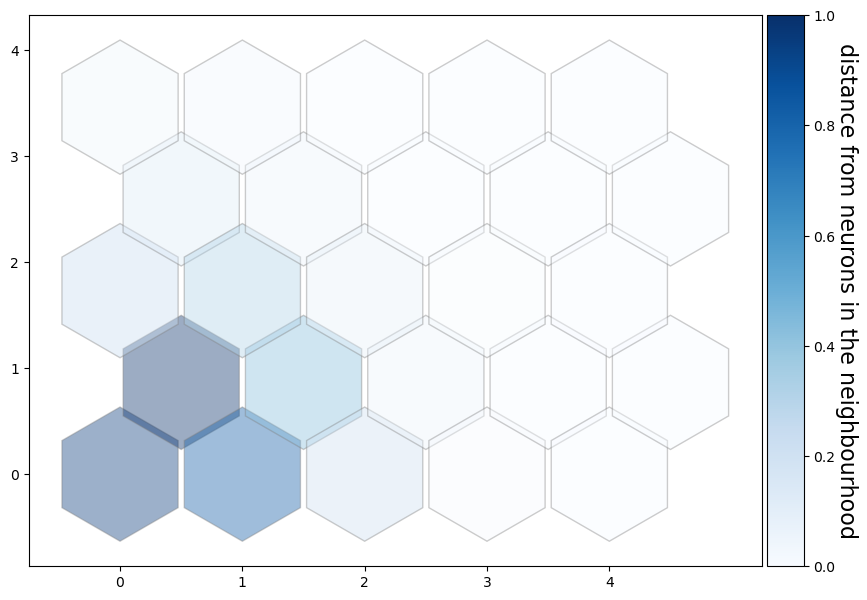

In [70]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

# markers = ['o', '+', 'x']
# colors = ['C0', 'C1', 'C2']
for cnt, x in enumerate(x_2023_knn):
    # getting the winner
    w = som.winner(x)
    # place a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * np.sqrt(3) / 2
    plt.plot(wx, wy)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

In [ ]:
https://github.com/JustGlowing/minisom/blob/master/examples/BasicUsage.ipynb

In [16]:
from sklearn_som.som import SOM

In [17]:
som = SOM(m=3, n=3, dim=X1.shape[1], lr=1, sigma=1, max_iter=3000, random_state=552)

In [18]:
som.fit(X1)

In [19]:
labels = som.predict(X1)

In [21]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 14, 1: 3, 2: 9, 3: 19, 4: 31, 5: 20, 6: 37, 7: 57, 8: 119}

In [20]:
pca = PCA(n_components=2)
components = pca.fit_transform(X1)

fig = px.scatter(components, x=0, y=1, color=labels)
fig.show()

In [22]:
df_st = X[X.columns]

df_st['labels'] = labels
df_st['bank_name'] = df_2019['bank_name']

In [24]:
df_st.head()

Н1 CAR  Н2 liquidity  Н3 liquidity     ROA     ROE     LTV  NPL Ratio  \
0  0.1473        1.8338        1.6735  0.0310  0.2056  0.6449     0.0246   
1  0.1105        1.1847        1.3505  0.0130  0.1162  0.2905     0.0244   
2  0.1207        1.9424        1.5203  0.0099  0.0811  0.6442     0.0237   
3  0.1234        1.8385        1.7768  0.0190  0.1500  0.4845     0.0756   
4  0.1892        0.9645        2.3274  0.0219  0.1818  0.2205     0.0263   

   NPL Coverage  Debt/TotalAssets  Deposits/TotalAssets  ...  NPL/TotalLoans  \
0        0.0581          0.683816              0.197159  ...        0.022940   
1        0.0433          0.710046              0.170724  ...        0.022853   
2        0.0651          0.659667              0.176998  ...        0.020849   
3        0.0896          0.616829              0.365238  ...        0.064383   
4        0.0573          0.770347              0.084363  ...        0.025670   

   LiquidAssetsRatio    Z-score  КредитыЮЛ/TotalAssets  КредитыФЛ/TotalAssets  \
0           0.055944  41.722587               0.423550               0.248511   
1           0.049587  30.092875               0.494217               0.199642   
2           0.062872  62.865279               0.573154               0.086417   
3           0.106956  10.001009               0.443423               0.173406   
4           0.022847  21.078056               0.703411               0.053514   

   ВыданныеМБК/TotalAssets  ПривлеченныеМБК/TotalAssets  Капитал/Активы  \
0                 0.047862                     0.031230        0.155673   
1                 0.047991                     0.051681        0.114109   
2                 0.090746                     0.021145        0.116780   
3                 0.107547                     0.038502        0.127373   
4                 0.018019                     0.215523        0.117960   

   labels                        bank_name  
0       7                         Сбербанк  
1       7                              ВТБ  
2       6                      Газпромбанк  
3       8                       Альфа-Банк  
4       5  Московский кредитный банк (МКБ)  

[5 rows x 22 columns]

In [29]:
print(df_st[df_st['bank_name'].isin(df_st[df_st['labels'] == 2]['bank_name'].values)]['bank_name'].values)
df_st[df_st['bank_name'].isin(df_st[df_st['labels'] == 2]['bank_name'].values)].describe()

['Драйв Клик Банк' 'Авто Финанс Банк' 'Банк «Пойдём!»'
 'Классик Эконом Банк' '«ПЕРЕСВЕТ»' 'Росэксимбанк' '«Расчетные Решения»'
 'РНКО «Единая касса»' '«ЭЛЕКСИР»']


Н1 CAR  Н2 liquidity  Н3 liquidity       ROA       ROE       LTV  \
count  9.000000      8.000000      9.000000  9.000000  9.000000  9.000000   
mean   0.540933      0.697087      1.722644  0.084422  0.319533  0.797978   
std    0.605204      0.752522      2.496590  0.106606  0.366323  0.993268   
min    0.120300      0.000000      0.000000  0.015600  0.047200  0.000000   
25%    0.169400      0.000000      0.000000  0.022900  0.103900  0.000000   
50%    0.350200      0.684600      0.826900  0.045900  0.123700  0.447100   
75%    0.599000      0.974500      2.166900  0.059600  0.353600  1.266400   
max    2.073700      2.204100      7.891500  0.321900  1.141100  2.891100   

       NPL Ratio  NPL Coverage  Debt/TotalAssets  Deposits/TotalAssets  ...  \
count   9.000000      9.000000          9.000000              9.000000  ...   
mean    0.105822      0.096922          0.471958              0.019717  ...   
std     0.186085      0.128831          0.358268              0.009092  ...   
min     0.000000      0.000000          0.000000              0.007563  ...   
25%     0.000000      0.000000          0.098358              0.014252  ...   
50%     0.042800      0.060900          0.539848              0.019372  ...   
75%     0.074600      0.085700          0.747482              0.026897  ...   
max     0.577000      0.400500          0.908507              0.031888  ...   

              LDR  NPL/TotalLoans  LiquidAssetsRatio    Z-score  \
count    9.000000        9.000000           9.000000   9.000000   
mean    47.981482        0.095676           0.331680  19.999808   
std     23.829631        0.175717           0.398211  12.298490   
min     23.243634        0.000000           0.000603   5.771079   
25%     32.583058        0.000000           0.055402   6.710180   
50%     36.528051        0.041293           0.110442  20.269084   
75%     58.119559        0.060738           0.607715  26.135495   
max    100.300634        0.544349           0.982708  37.693416   

       КредитыЮЛ/TotalAssets  КредитыФЛ/TotalAssets  ВыданныеМБК/TotalAssets  \
count               9.000000               9.000000                 9.000000   
mean                0.198776               0.267840                 0.312323   
std                 0.274131               0.359686                 0.365462   
min                 0.000000               0.000000                 0.000000   
25%                 0.000234               0.000000                 0.041901   
50%                 0.034126               0.011538                 0.106244   
75%                 0.429137               0.537854                 0.393311   
max                 0.687754               0.908273                 0.982478   

       ПривлеченныеМБК/TotalAssets  Капитал/Активы  labels  
count                     9.000000        9.000000     9.0  
mean                      0.174899        0.316281     2.0  
std                       0.253653        0.265439     0.0  
min                       0.000000        0.171476     2.0  
25%                       0.000000        0.175228     2.0  
50%                       0.024718        0.207867     2.0  
75%                       0.263006        0.263664     2.0  
max                       0.762159        0.971039     2.0  

[8 rows x 21 columns]

$S_i = \dfrac{b_i-a_i}{max(b_i, a_i)}$



$DB(i) = max_{i \not= j}\dfrac{\delta_i + \delta_j}{d(i, j)}$

$z= \dfrac{x-\mu}{\sigma}$

Метрики качества клатеризации

https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8